In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import ast

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf

##### Verify TensorFlow and Python version

In [3]:
print(tf.__version__)

('2.10.0',)

In [4]:
from platform import python_version

print(python_version())

3.8.12


##### Load testing data

In [ ]:
# Load the test data
# Training and validation sets are not used in this inference notebook
test = pd.read_csv(r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\unknow test-05182024-5.csv")

def transform_label(label):
    if label in (["['AF']", "['AgNR@SiO2']", "['DMEM']", "[]"]):
        return "['Reference']"
    
    if 'COVNL63' in label or 'CoVNL63' in label or 'CovNL63' in label:
        return label.replace('COVNL63', 'CoVNL63').replace('CovNL63', 'CoVNL63')
    
    return label

# Apply the custom function to the "Label" column
test['Label'] = test['Label'].apply(transform_label)

# Prepare X (features)
X_test = test.iloc[:, :-2].values

# Standardize X
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Reshape the dataset
sample_size_test = X_test_scaled.shape[0]
time_steps_test = X_test_scaled.shape[1]
input_dimension = 1
X_test_reshape = X_test_scaled.reshape(sample_size_test, time_steps_test, input_dimension)

# Prepare labels and concentrations
label_test = [ast.literal_eval(label) for label in test['Label']]
conc_test = [ast.literal_eval(conc) for conc in test['Conc']]

# Classification
mlb = MultiLabelBinarizer()
y_test_class = pd.DataFrame(mlb.fit_transform(label_test), columns=mlb.classes_)

# Regression
y_test_reg = np.zeros(y_test_class.shape)
for i in range(y_test_class.shape[0]):
    y_test_reg[i][y_test_class.values[i] == 1] = np.log10([x + 1e-20 for x in conc_test[i]]) # Add 1e-20 to make log(reference) not to be -inf
y_test_reg = pd.DataFrame(y_test_reg, columns=mlb.classes_)

#### Multi-task model

Load the pre-trained model

In [ ]:
# Load the pre-trained model
model_path = r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Models above LOD\Subset_Model_499.h5"
model = tf.keras.models.load_model(model_path, compile=False)

# Make predictions
y_hat_class, y_hat_reg = model.predict(X_test_reshape)

# Evaluate accuracy for classification
y_hat_class_rounded = y_hat_class.round()
acc = accuracy_score(y_test_class, y_hat_class_rounded)
print('Classification Accuracy: %.3f' % acc)

# Calculate error for regression
error = np.abs(y_test_reg - y_hat_reg).sum() / y_hat_reg.shape[0]
print('Regression Error: %.3f' % error)

Prediction visualization

In [58]:
# Convert 0-1 label to string
y_true_label = test['Label'].values
classes = np.unique(y_test_class.columns)

y_pred_label = []
for i in range(y_hat_class.shape[0]):
    ind = np.where(y_hat_class[i] >= 0.5)  # Using 0.5 as threshold
    label = list(classes[ind])
    y_pred_label.append(str(label))

y_pred_label = np.array(y_pred_label)

Classification part

In [ ]:
# Function to create confusion matrix
def create_confusion_matrix(true_labels, pred_labels):
    index = np.unique(true_labels)
    index = sorted(index, key=lambda x: (x.count(','), x))
    cm = confusion_matrix(true_labels, pred_labels, labels=index)
    return cm, index

# Function to plot confusion matrix
def plot_confusion_matrix(cm, index, title, is_percentage=False):
    plt.figure(figsize=(20, 20))
    if is_percentage:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        fmt = ".1f"
    else:
        fmt = "d"
    
    cm_df = pd.DataFrame(cm, index, index)
    ax = sns.heatmap(cm_df, annot=False, fmt=fmt, cmap='Blues_r', linewidths=2, linecolor='black')
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] != 0:
                text_color = 'white' if cm[i, j] < (cm.max() / 2) else 'black'
                ax.text(j + 0.5, i + 0.5, f"{cm[i, j]:{fmt}}",
                        fontsize=14, horizontalalignment='center',
                        verticalalignment='center', color=text_color)
    
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    ax.collections[0].colorbar.remove()
    plt.show()

0.9445


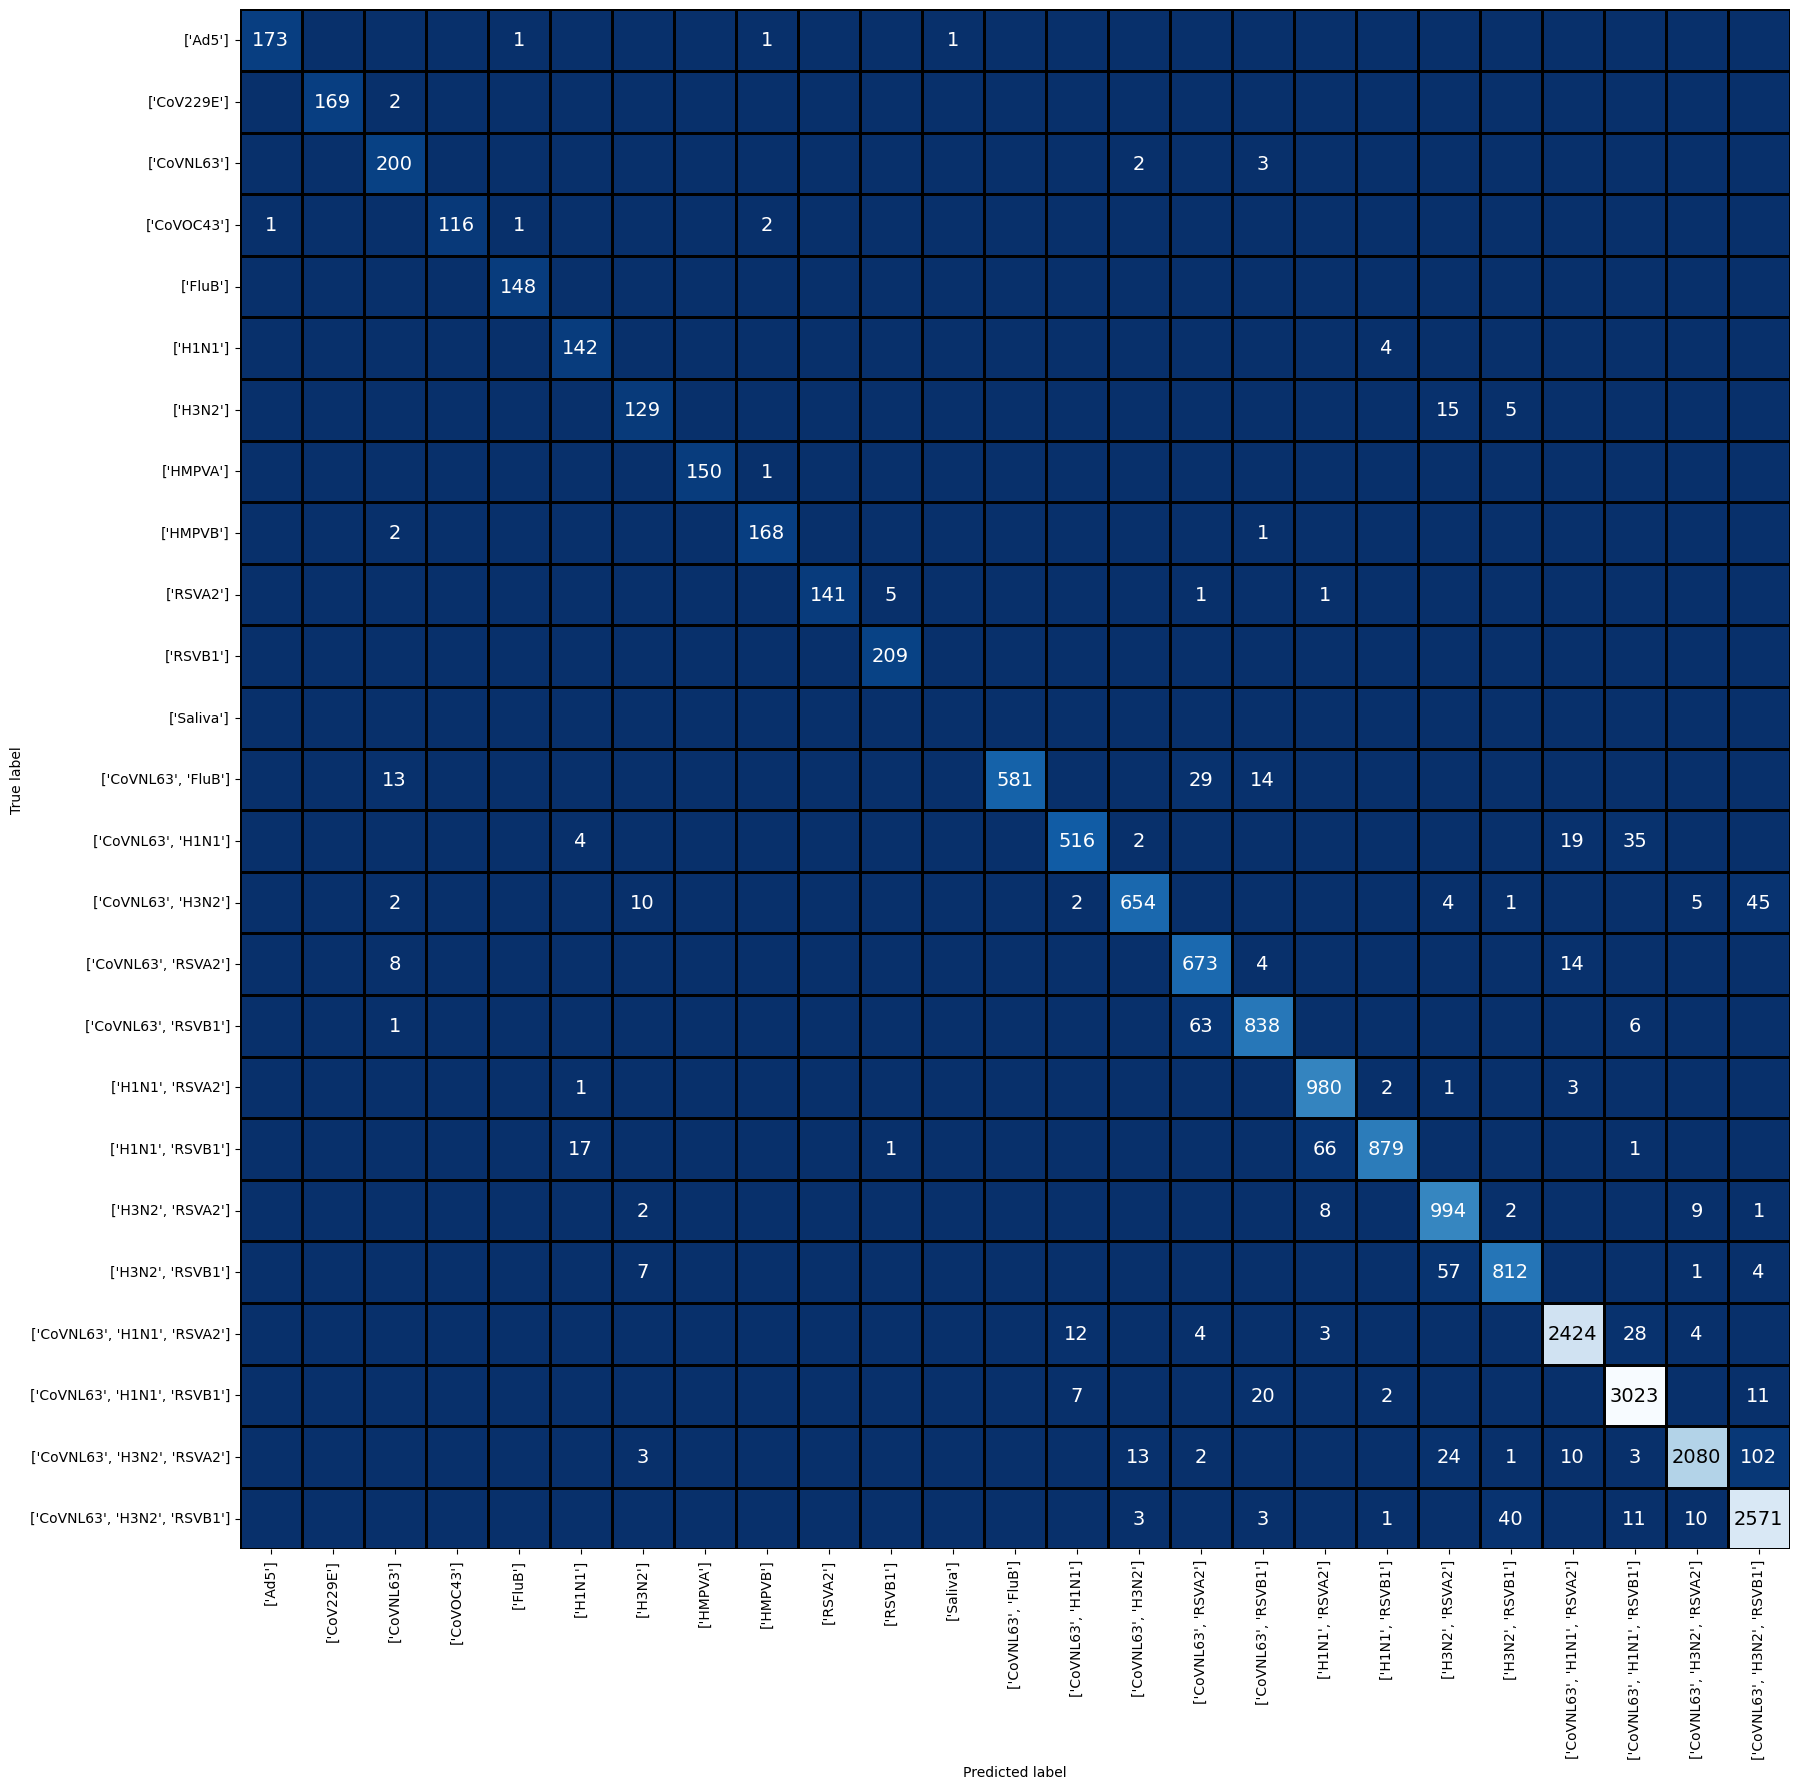

In [59]:
# Overall classification accuracy
print(f"Overall accuracy: {accuracy_score(y_true_label, y_pred_label):.4f}")

# Overall confusion matrix
cm, index = create_confusion_matrix(y_true_label, y_pred_label)
plot_confusion_matrix(cm, index, "Overall Confusion Matrix")

In [21]:
# Save confusion matrices
pd.DataFrame(cm, index=index, columns=index).to_csv(r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\unknown test_confusion matrix_test_LOD_spectra number.csv")

C:\Users\yanju\AppData\Local\Temp\ipykernel_5288\3696846565.py:2: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
C:\Users\yanju\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\yanju\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


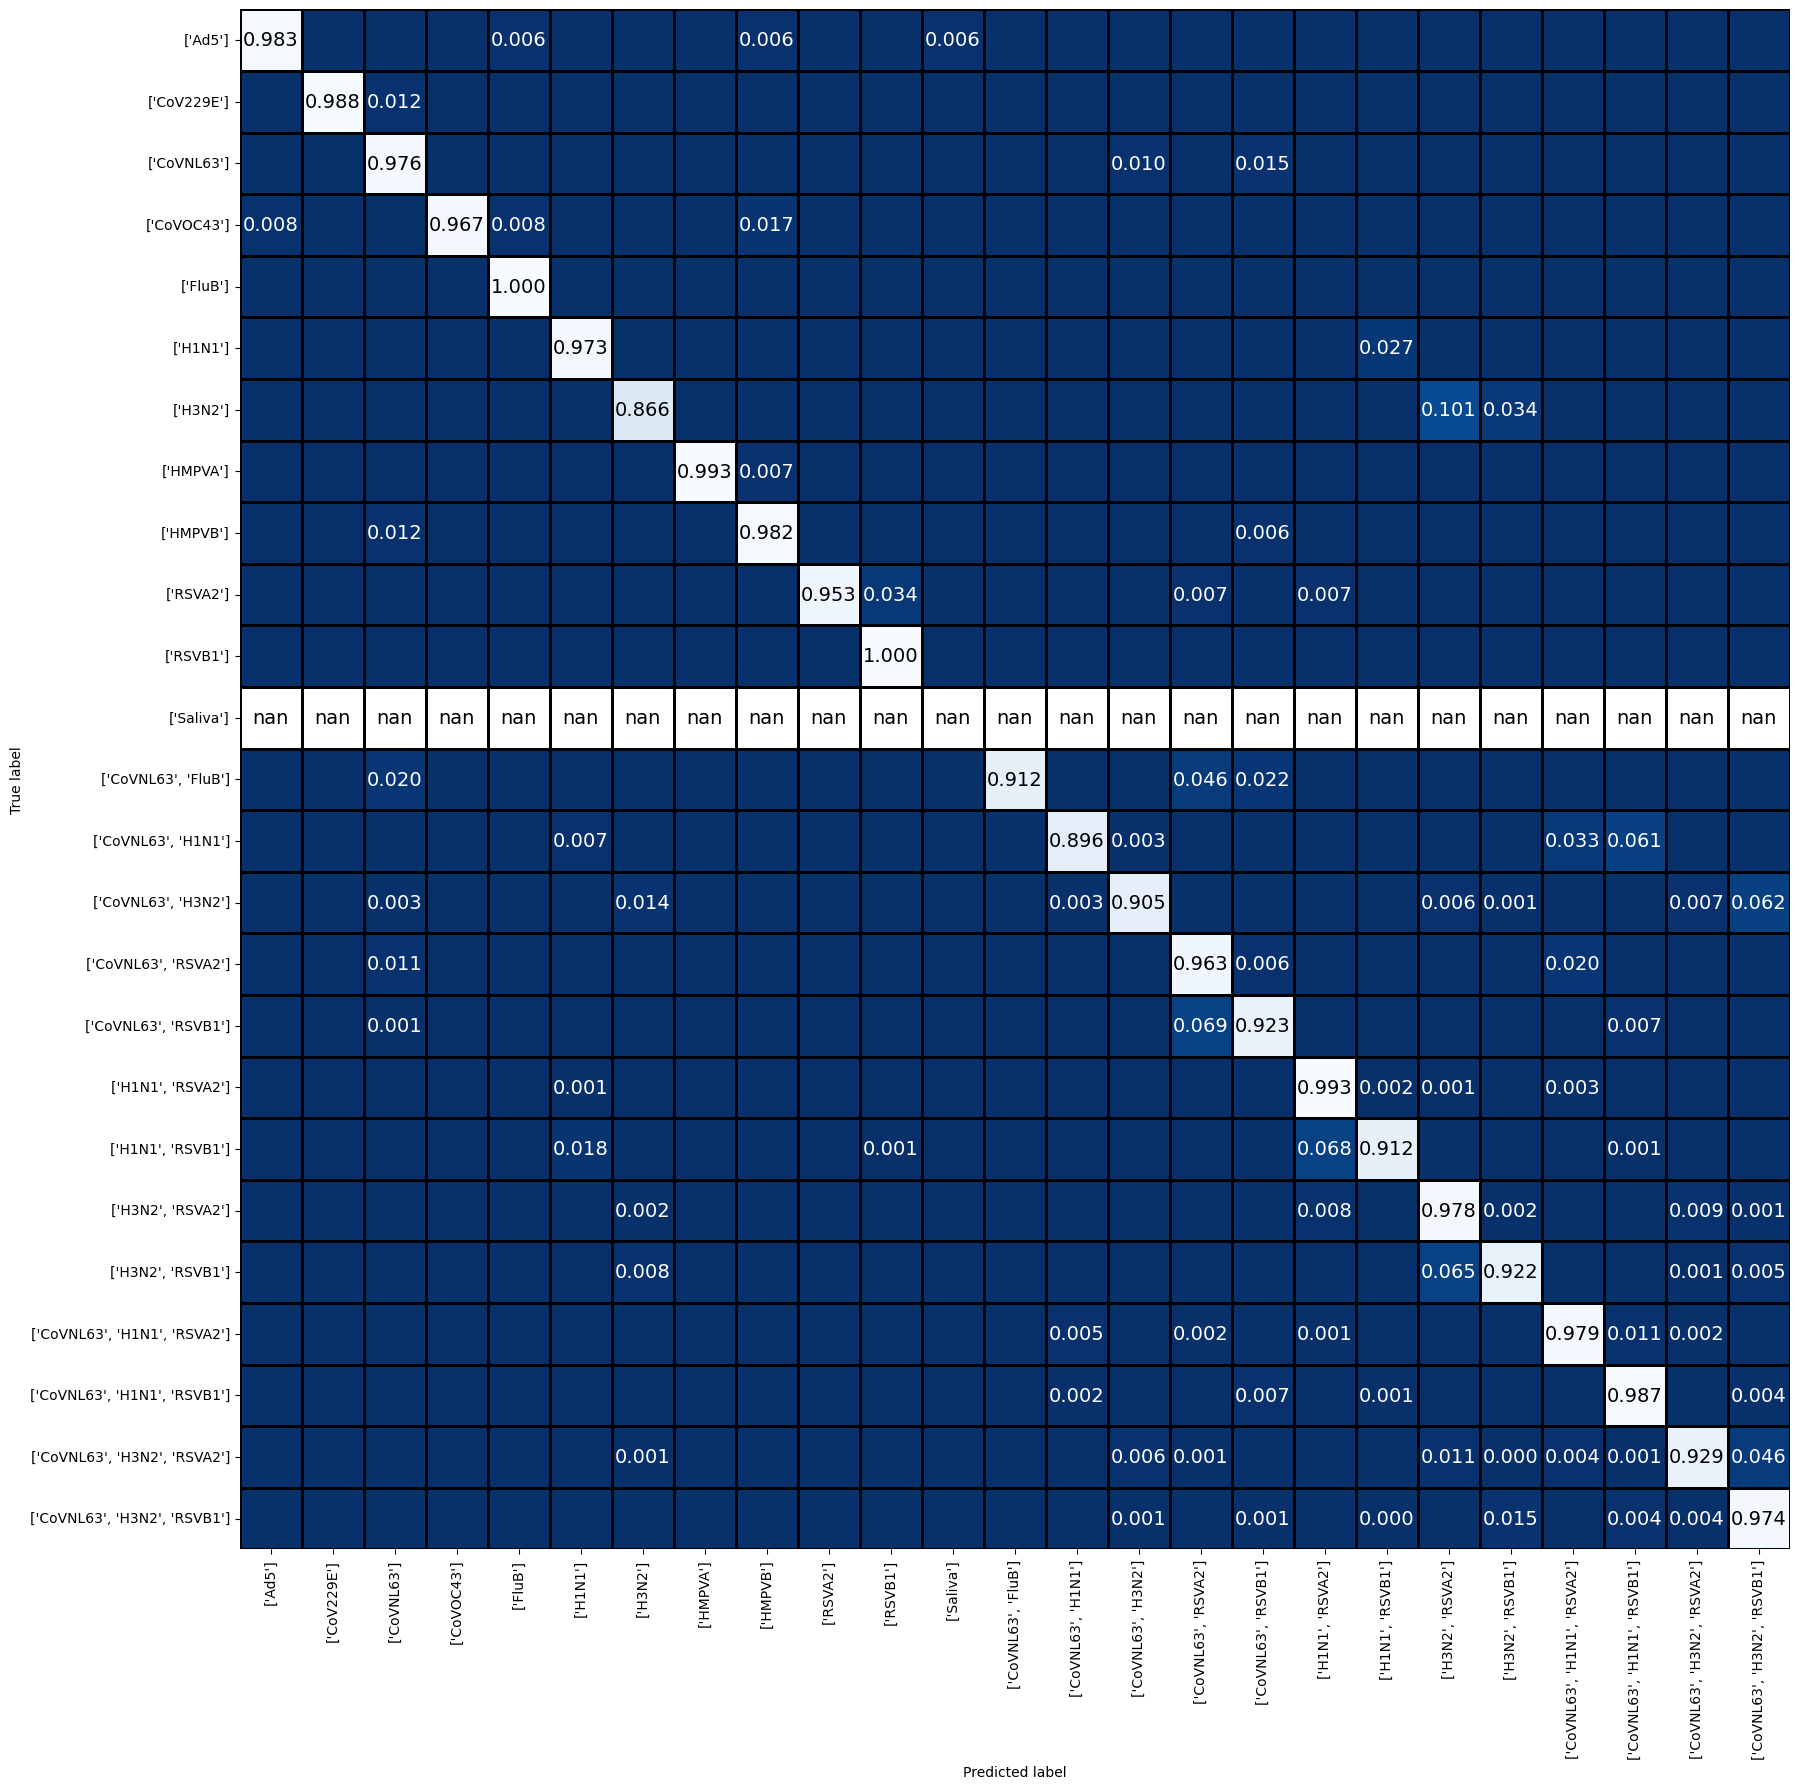

In [60]:
plot_confusion_matrix(cm, index, "Overall Confusion Matrix (Percentage)", is_percentage=True)

In [59]:
# Save confusion matrices
pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100, index=index, columns=index).to_csv(r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\unknown test_confusion matrix.csv")

In [61]:
# Separate single, dual, and triple cases
single_index = np.sum(y_test_class.values, axis = 1)==1
dual_index = np.sum(y_test_class.values, axis = 1) == 2
triple_index = np.sum(y_test_class.values, axis = 1) == 3 

# single
single_y_true_label = y_true_label[single_index]
single_y_pred_label = y_pred_label[single_index]

# dual
dual_y_true_label = y_true_label[dual_index]
dual_y_pred_label = y_pred_label[dual_index]

# triple
triple_y_true_label = y_true_label[triple_index]
triple_y_pred_label = y_pred_label[triple_index]

Accuracy for Confusion Matrix for Single Virus Cases: 0.9727


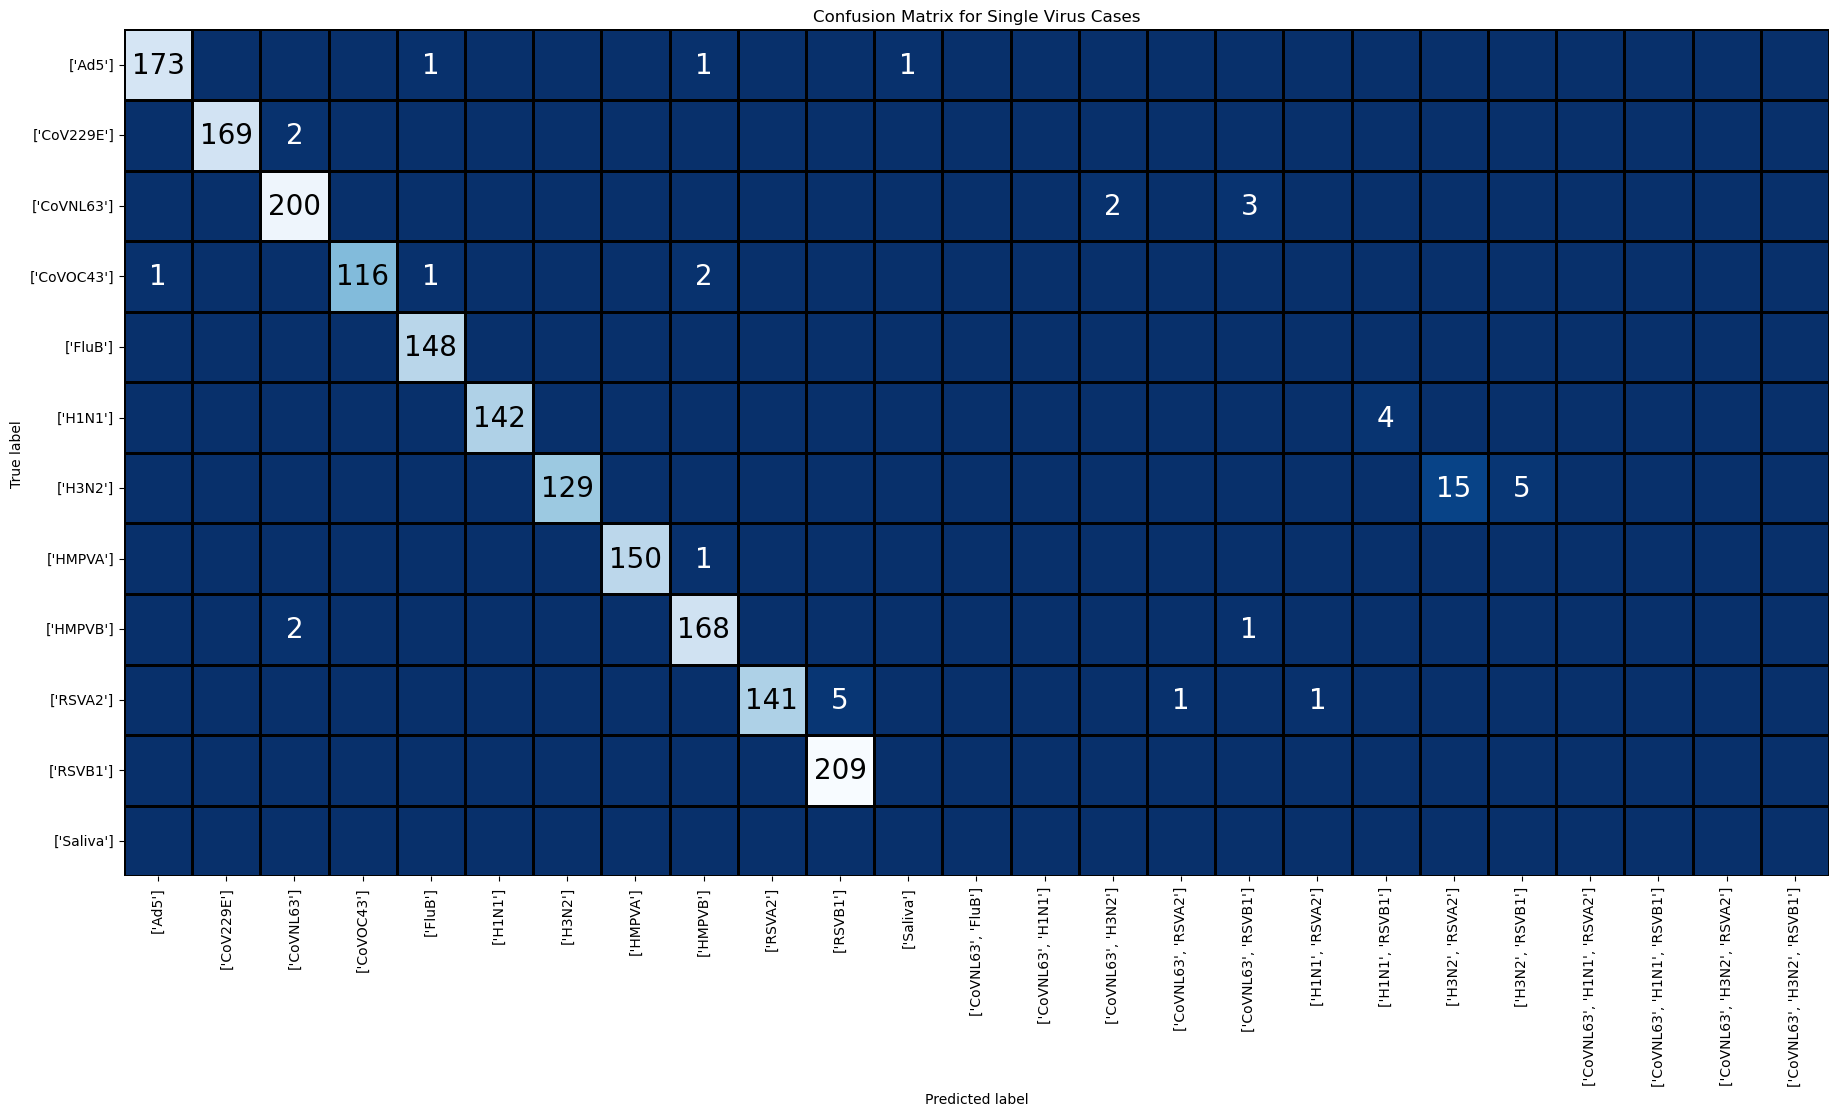

Accuracy for Confusion Matrix for Double Virus Cases: 0.9372


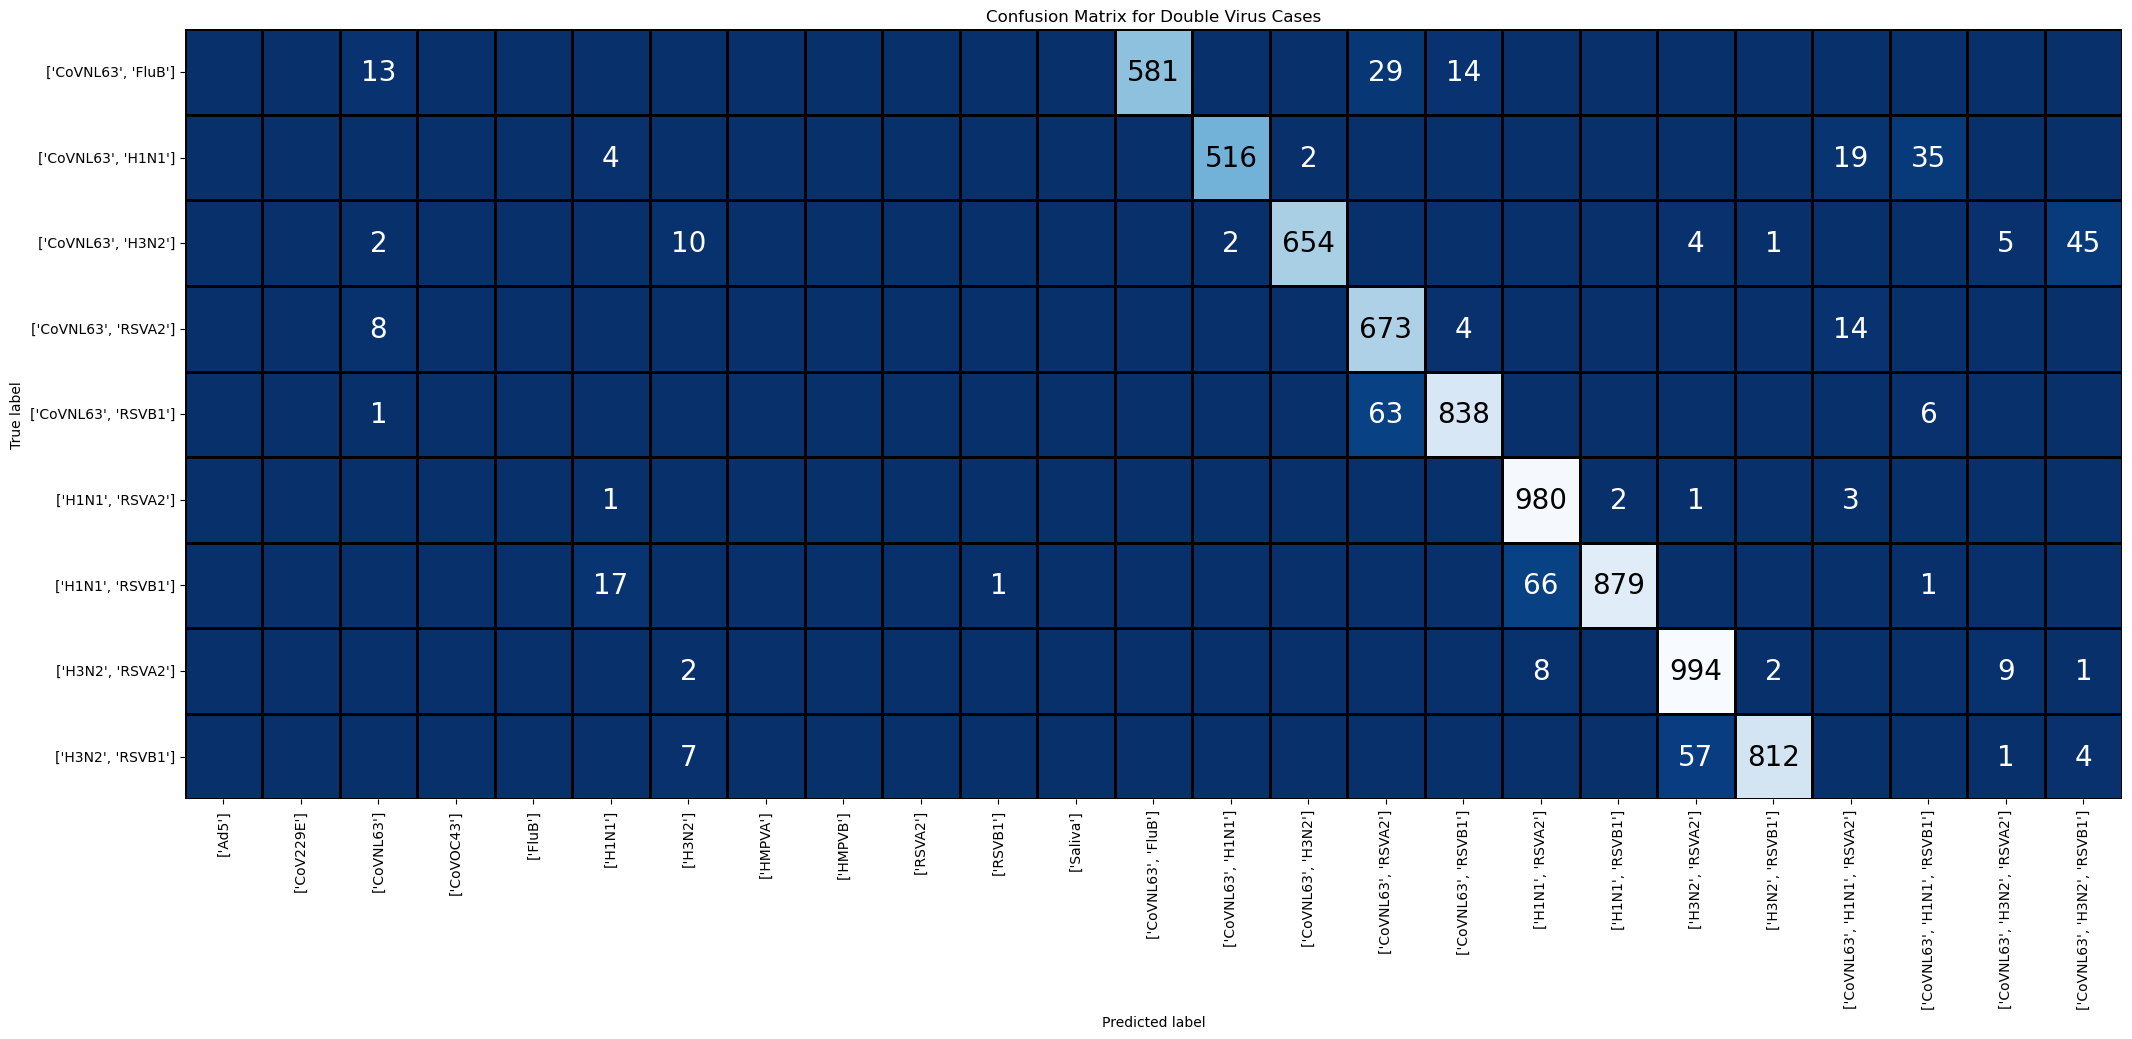

Accuracy for Confusion Matrix for Triple Virus Cases: 0.9696


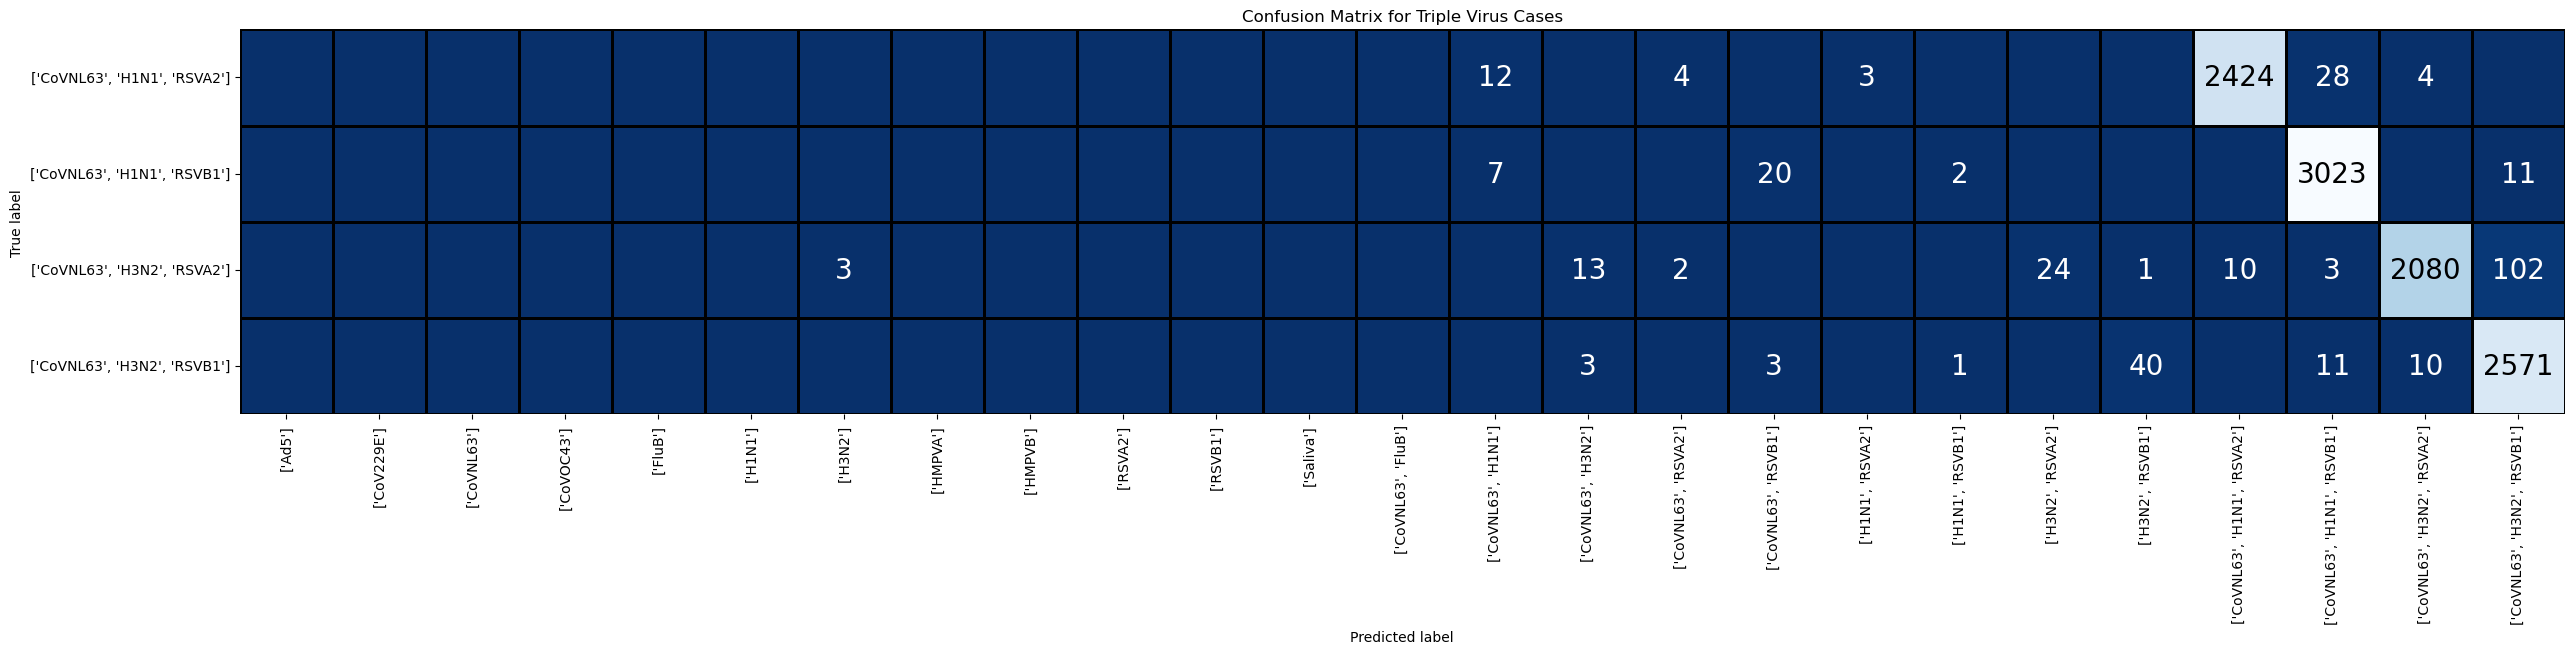

In [62]:
# Function to create and plot a submatrix
def plot_submatrix(cm, labels, index, title, is_percentage=False):
    cm_sub = cm[np.isin(index, labels), :]
    cm_sub = cm_sub[:, np.isin(index, labels)]
    cm_df = pd.DataFrame(cm_sub, index=labels, columns=labels)
    
    if is_percentage:
        cm_sub = cm_sub.astype('float') / cm_sub.sum(axis=1)[:, np.newaxis] * 100
        fmt = ".1f"
    else:
        fmt = "d"
    
    plt.figure(figsize=(20, 20))
    ax = sns.heatmap(cm_df, annot=False, fmt=fmt, cmap='Blues_r', linewidths=2, linecolor='black')
    
    for i in range(cm_sub.shape[0]):
        for j in range(cm_sub.shape[1]):
            if cm_sub[i, j] != 0:
                text_color = 'white' if cm_sub[i, j] < (cm_sub.max() / 2) else 'black'
                ax.text(j + 0.5, i + 0.5, f"{cm_sub[i, j]:{fmt}}",
                        fontsize=14, horizontalalignment='center',
                        verticalalignment='center', color=text_color)
    
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    ax.collections[0].colorbar.remove()
    plt.show()
    
    if not is_percentage:
        accuracy = np.trace(cm_sub) / np.sum(cm_sub)
        print(f'Accuracy for {title}: {accuracy:.4f}')

# Overall confusion matrix
index = np.unique(y_true_label)

# Sort the labels by length and then alphabetically
index = sorted(index, key=lambda x: (x.count(','), x))
cm = confusion_matrix(y_true_label, y_pred_label, labels=index)

# single, double, triple labels
single_labels = np.unique(single_y_true_label)
double_labels = np.unique(dual_y_true_label)
triple_labels = np.unique(triple_y_true_label)

# Plotting the submatrices
plt.figure(figsize=(22, 11))
plot_submatrix(cm, single_labels, index, "Confusion Matrix for Single Virus Cases")

plt.figure(figsize=(25, 10))
plot_submatrix(cm, double_labels, index, "Confusion Matrix for Double Virus Cases")

plt.figure(figsize=(30, 5))
plot_submatrix(cm, triple_labels, index, "Confusion Matrix for Triple Virus Cases")

C:\Users\yanju\AppData\Local\Temp\ipykernel_5288\2788409589.py:4: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


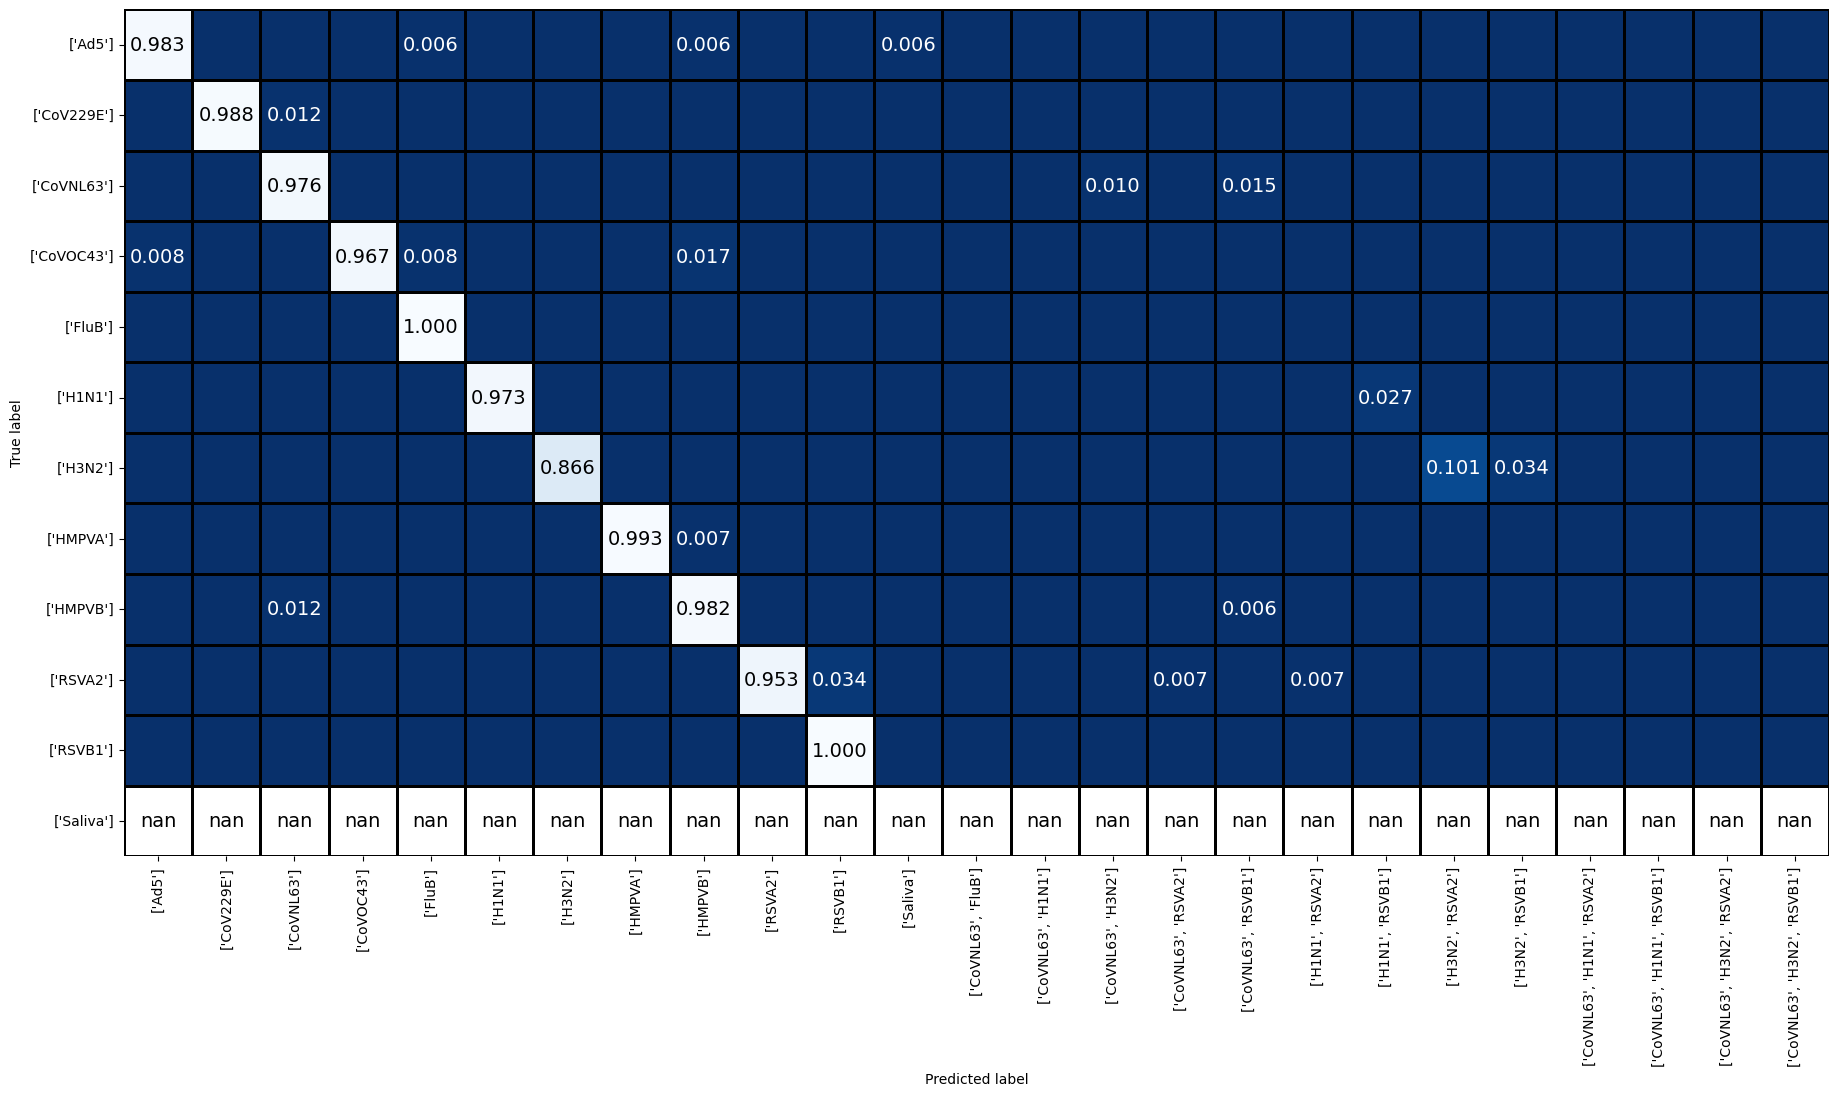

C:\Users\yanju\AppData\Local\Temp\ipykernel_5288\2788409589.py:4: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


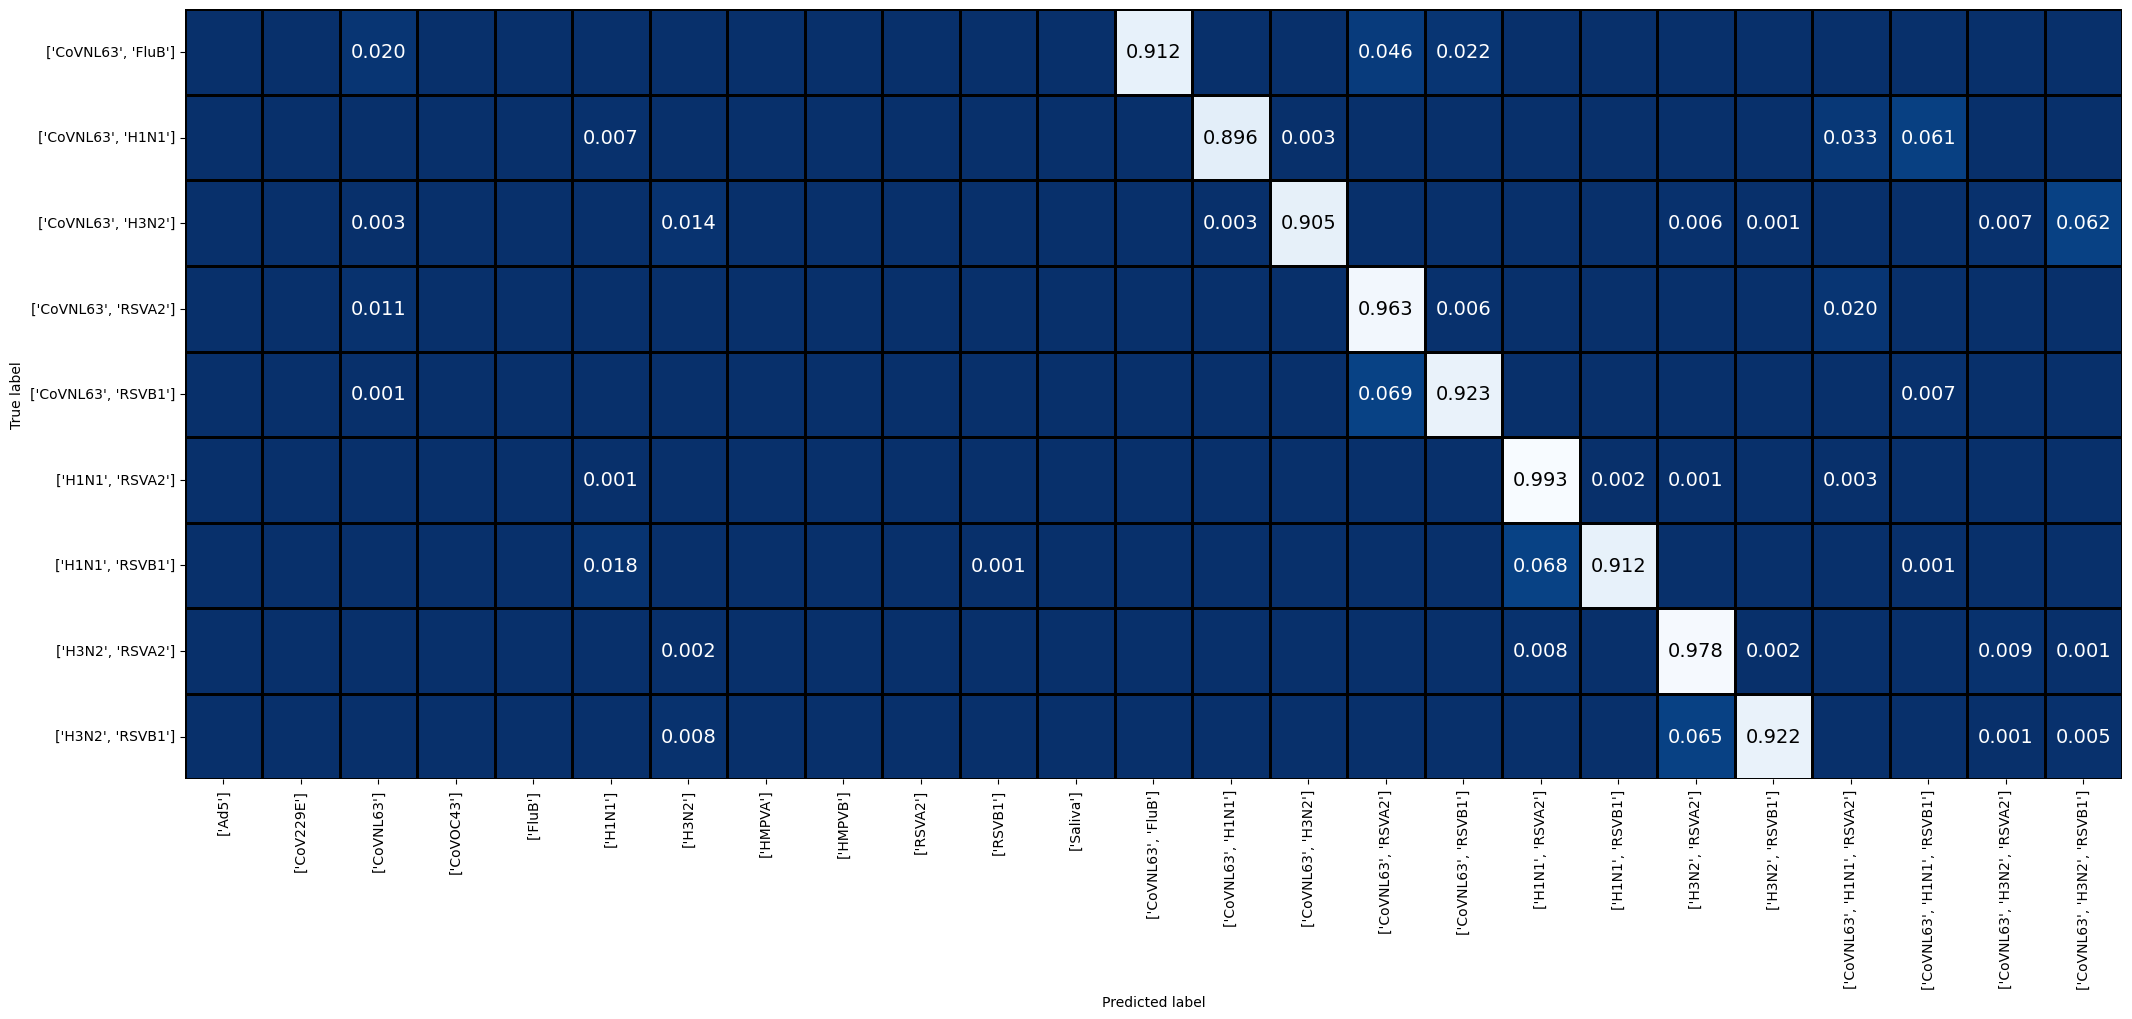

C:\Users\yanju\AppData\Local\Temp\ipykernel_5288\2788409589.py:4: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


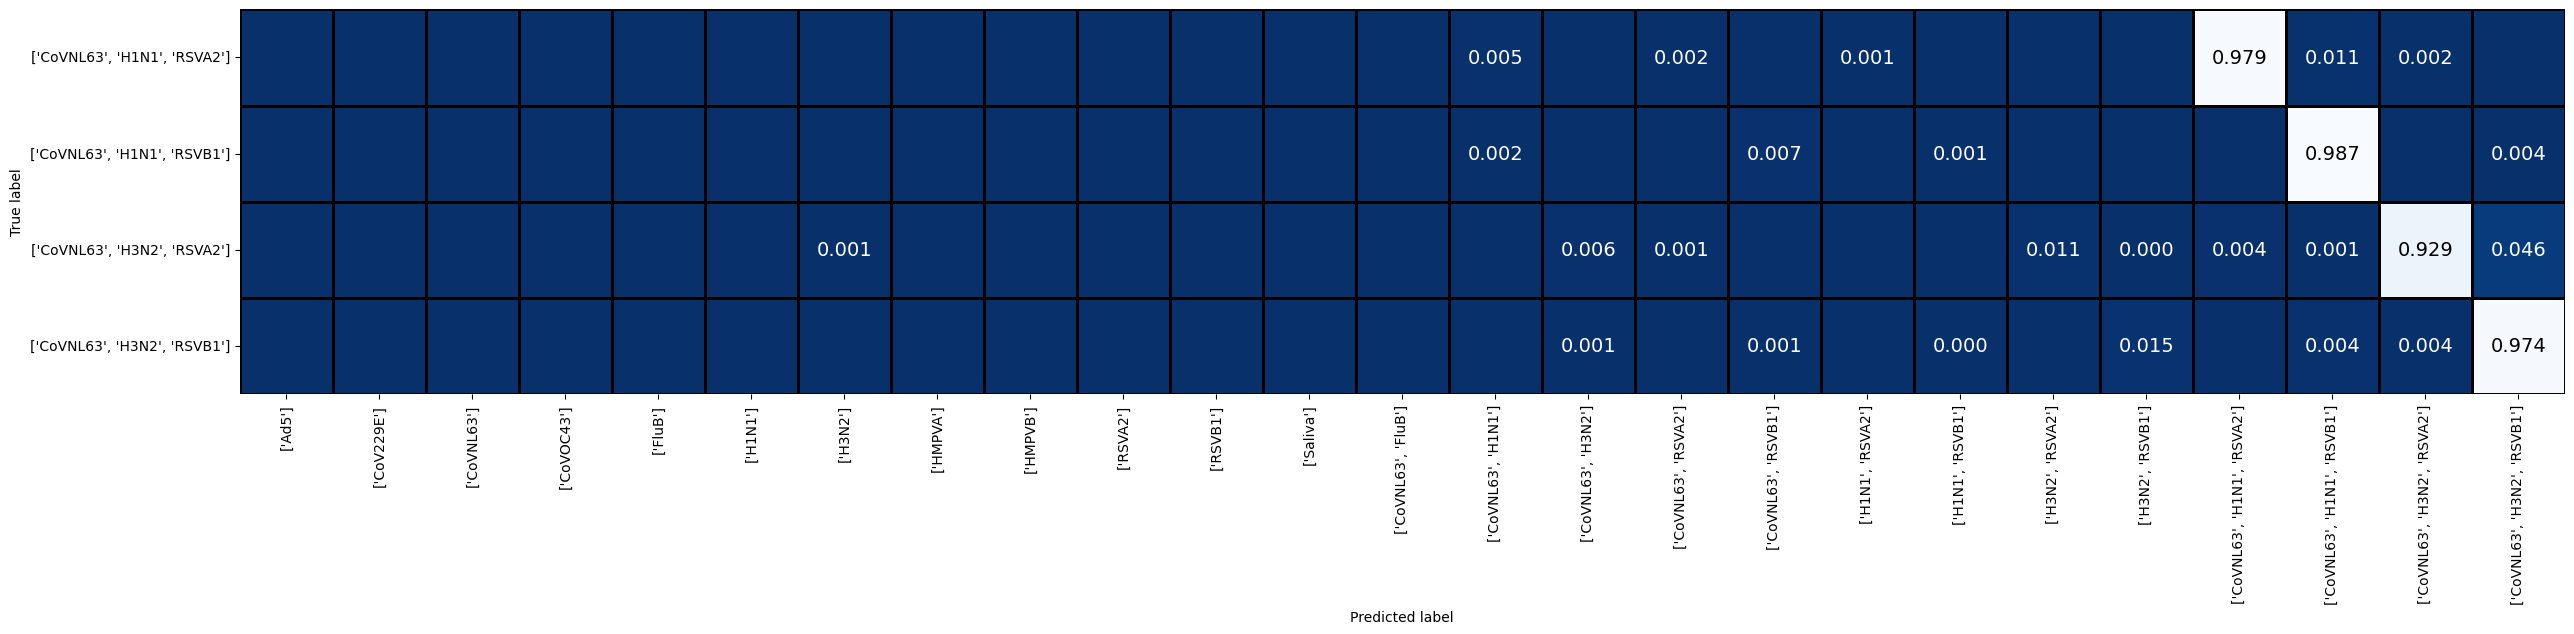

In [63]:
# Plotting the percentage submatrices
plt.figure(figsize=(22, 11))
plot_submatrix(cm, single_labels, index, "Percentage Confusion Matrix for Single Virus Cases", is_percentage=True)

plt.figure(figsize=(25, 10))
plot_submatrix(cm, double_labels, index, "Percentage Confusion Matrix for Double Virus Cases", is_percentage=True)

plt.figure(figsize=(30, 5))
plot_submatrix(cm, triple_labels, index, "Percentage Confusion Matrix for Triple Virus Cases", is_percentage=True)

In [64]:
# Misclassification analysis
mis_index = np.where(y_true_label != y_pred_label)
true_y = y_true_label[mis_index]
pred_y = y_pred_label[mis_index]
y_true_conc = test['Conc'].values
true_y_conc = y_true_conc[mis_index]

def process_predictions(predictions, true_conc):
    pred_list = ast.literal_eval(predictions)
    pred_conc_list = []
    for pred in pred_list:
        pred_str = str([pred])
        pred_idx = next((i for i, x in enumerate(index) if x == pred_str), None)
        if pred_idx is None:
            raise ValueError(f"No matching index found for {pred_str}")
        pred_conc = 10 ** y_hat_reg[mis_index][i][pred_idx]
        pred_conc_list.append(pred_conc)
    return pred_list, pred_conc_list

# Process all samples (both misclassified and correctly classified)
all_classifications = []
for i in range(len(y_true_label)):
    true_label = y_true_label[i]
    pred_label = y_pred_label[i]
    true_conc = y_true_conc[i]
    pred_list, pred_conc_list = process_predictions(pred_label, true_conc)
    all_classifications.append({
        'True_Label': true_label,
        'True_Conc': true_conc,
        'Pred_Label': pred_label,
        'Pred_Conc': pred_conc_list,
        'Misclassified': true_label != pred_label
    })

# Create DataFrames
classification_df = pd.DataFrame(all_classifications)
mis_df = classification_df[classification_df['Misclassified']]

In [50]:
# Save misclassification DataFrame
mis_df.to_csv(r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Models above LOD\Classification accuracy\misclassification_df.csv", index=False)

In [ ]:
# Calculate accuracy for each group
grouped = classification_df.groupby(['True_Label', 'True_Conc'])
accuracy_dict = {
    (label, conc): {
        'Total': len(group),
        'Correct': len(group[group['True_Label'] == group['Pred_Label']]),
        'Accuracy': len(group[group['True_Label'] == group['Pred_Label']]) / len(group)
    }
    for (label, conc), group in grouped
}

accuracy_df = pd.DataFrame.from_dict(accuracy_dict, orient='index')

In [60]:
accuracy_df.to_csv(r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\unknown test_accuracy.csv", index=True)

In [40]:
# Print misclassification summary
print(mis_df.groupby(['True_Label', 'Pred_Label']).size().unstack(fill_value=0))

True_Label           Pred_Label                  
['Ad5']              ['HMPVA']                        (6, 4)
                     []                               (7, 4)
['CoV229E']          ['HMPVA']                        (1, 4)
                     ['RSVB1']                        (1, 4)
['CoVNL63', 'FluB']  ['CoVNL63', 'FluB', 'RSVB1']    (10, 4)
                                                      ...   
['RSVB1']            ['H3N2', 'RSVB1']                (6, 4)
                     []                               (3, 4)
['Reference']        ['H3N2', 'RSVB1']                (5, 4)
                     ['RSVB1', 'Reference']           (1, 4)
                     []                               (1, 4)
Length: 100, dtype: object


Regression part

In [68]:
def calculate_MAE_and_R_square(real, predicted):
    MAE = np.abs(real-predicted).sum()/predicted.shape[0]
    y_mean = np.mean(real)
    ess = np.sum((predicted - real)**2)
    tss = np.sum((real - y_mean)**2)
    R = 1 - ess / tss
    return MAE, R

In [69]:
summary_list = [] # Used for LOD determination, contains all the  'Virus_Type', 'Real_Concentration', 'Predicted_Concentration'

In [72]:
R1_list

[0.9886542258766764,
 0.9937889717400837,
 0.9856973692440829,
 0.9816502746302923,
 0.985975541360386,
 0.9751847593020109,
 0.9942906258199863,
 0.9924184398144544,
 0.9779598054932899,
 0.9315477541289099,
 0.993778119689672,
 -inf]

C:\Users\yanju\AppData\Local\Temp\ipykernel_5288\986160779.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))
C:\Users\yanju\AppData\Local\Temp\ipykernel_5288\3700860946.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  R = 1 - ess / tss


IndexError: index 12 is out of bounds for axis 0 with size 12

<Figure size 500x500 with 0 Axes>

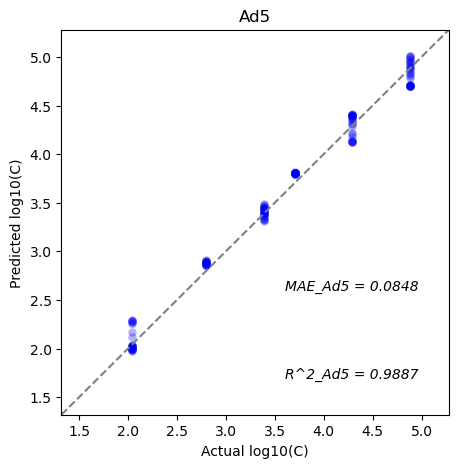

<Figure size 500x500 with 0 Axes>

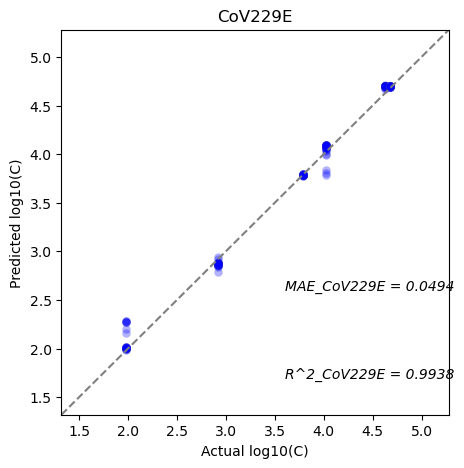

<Figure size 500x500 with 0 Axes>

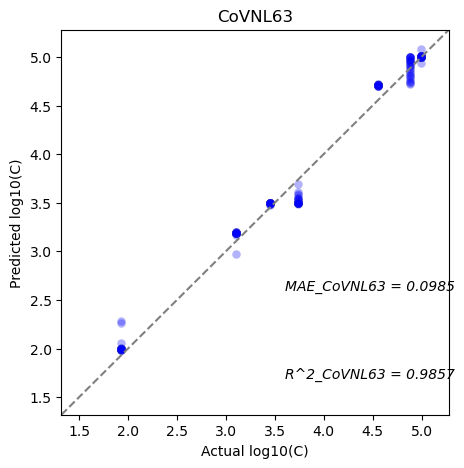

<Figure size 500x500 with 0 Axes>

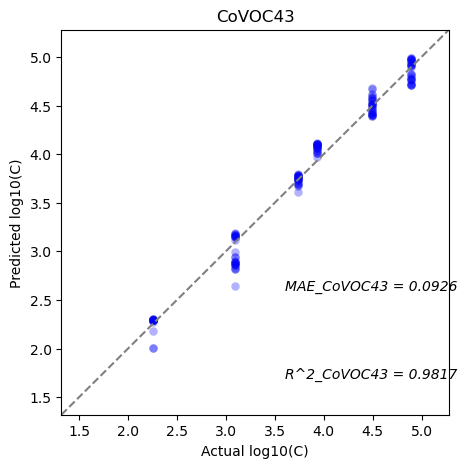

<Figure size 500x500 with 0 Axes>

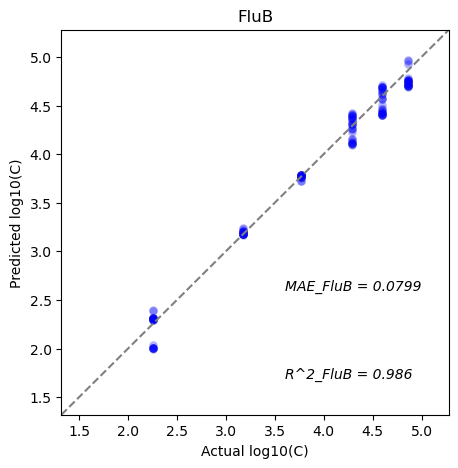

<Figure size 500x500 with 0 Axes>

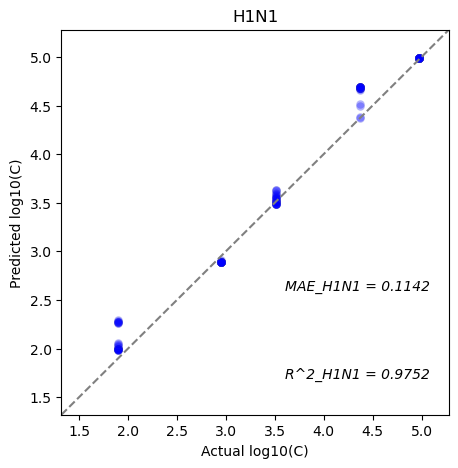

<Figure size 500x500 with 0 Axes>

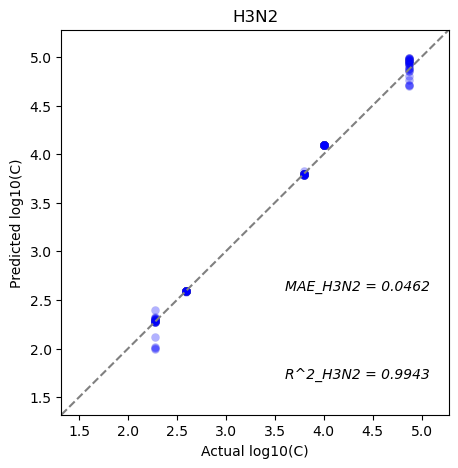

<Figure size 500x500 with 0 Axes>

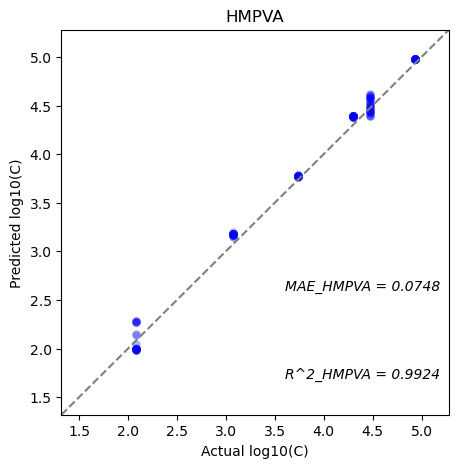

<Figure size 500x500 with 0 Axes>

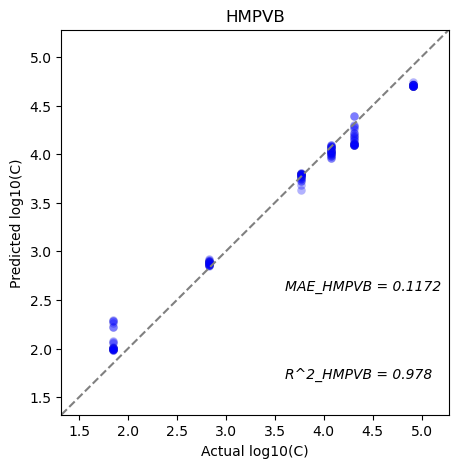

<Figure size 500x500 with 0 Axes>

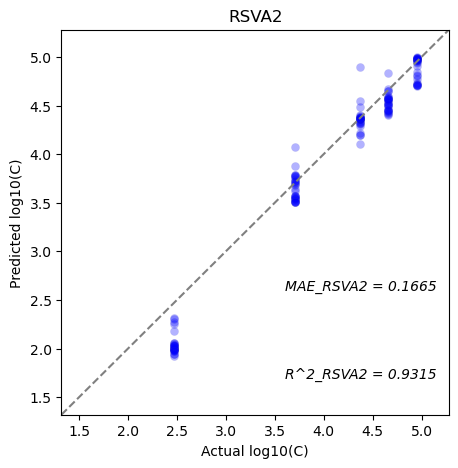

<Figure size 500x500 with 0 Axes>

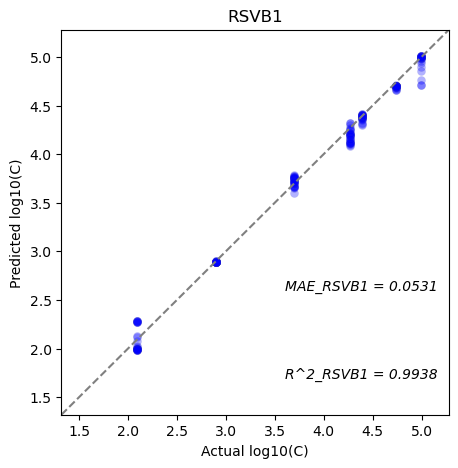

<Figure size 500x500 with 0 Axes>

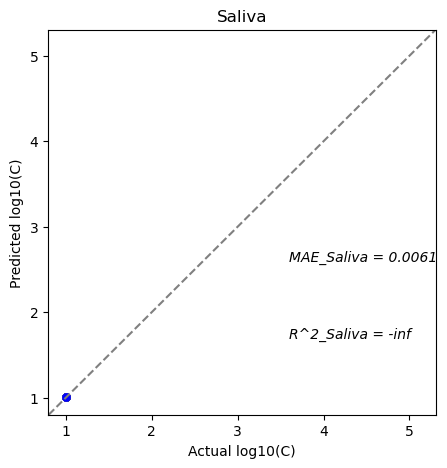

<Figure size 500x500 with 0 Axes>

In [73]:
## single
single_y_test_reg = y_test_reg.values[single_index,:]
single_y_hat_reg = y_hat_reg[single_index,:]
single_true_label = y_true_label[single_index]
cls = np.unique(single_true_label)

MAE1_list = []
R1_list = []

save_folder = r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\Regression\Single"

for i in range(len(cls)-1):
    plt.figure(figsize=(5, 5))
    single = ast.literal_eval(cls[i])
    ind = np.where(y_true_label==cls[i])
    
    single_y_test_reg = y_test_reg.values[ind,:][0]
    single_y_hat_reg = y_hat_reg[ind,:][0]
    not_outlier = np.where((single_y_hat_reg[:, i] > -25) & (single_y_hat_reg[:, i] < 8))
    real = single_y_test_reg[:,i][not_outlier]
    predicted = single_y_hat_reg[:,i][not_outlier]
    
    c = np.nonzero(np.all(single_y_test_reg != 0, axis=0))[0]
    MAE1, R1 = calculate_MAE_and_R_square(single_y_test_reg[:,c[0]], single_y_hat_reg[:,c[0]])
    MAE1_list.append(MAE1)
    R1_list.append(R1)
    
    # Loop through each element in the concentration arrays
    virus_type = mlb.classes_[i]
    summary_dict = {
        'Virus_Type': virus_type,
        'Real_Concentration': real,
        'Predicted_Concentration': predicted
    }
    summary_single = pd.DataFrame(summary_dict)
    pd.DataFrame(summary_single).to_csv(save_folder + r'/' + virus_type + ' - single.csv',index=True)    
    summary_list.append(summary_dict)  

    plt.figure(figsize=(5,5))
    plt.scatter(real, predicted,color="blue",edgecolors="grey",alpha = 0.3, linewidths=0.1)
   
    plt.axline((1.5,1.5),(5.1,5.1),linestyle='--', color="grey")
    plt.text(x=3.6,y=2.6,s="MAE_"+single[0]+" = " +str(round(MAE1,4)),style='oblique')
    plt.text(x=3.6,y=1.7,s="R^2_"+single[0]+" = " +str(round(R1,4)),style='oblique')

    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.title(virus_type)

for item in MAE1_list:
    print(item.round(4))
print()
for item in R1_list:
    print(item.round(4))
print()
plt.show()

# Note: for saliva, there is only one possible concentration, thus R^2 cannot be calculated. Please ignore the warning

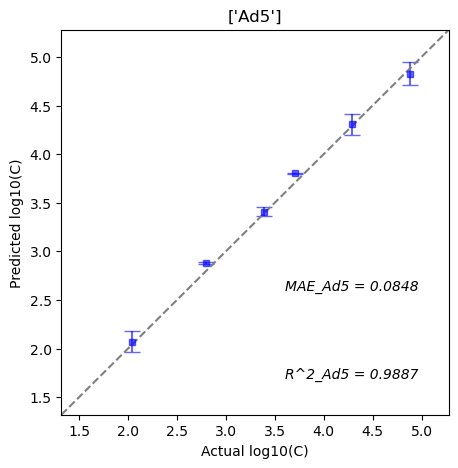

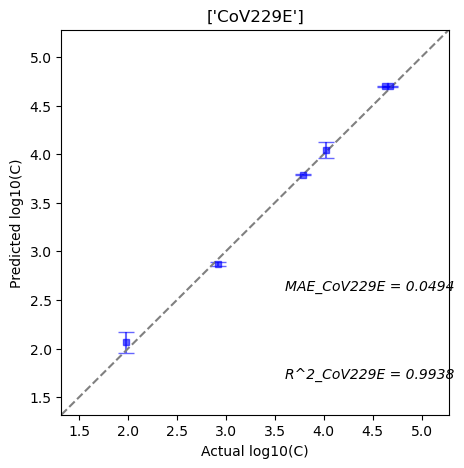

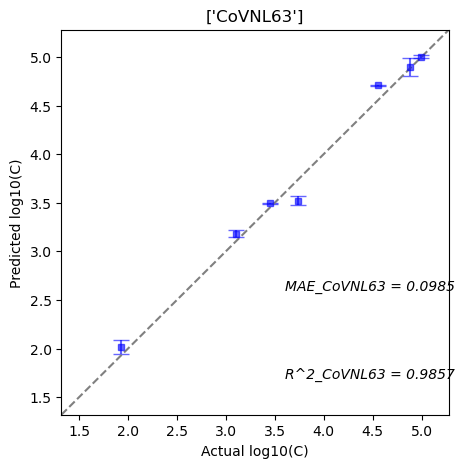

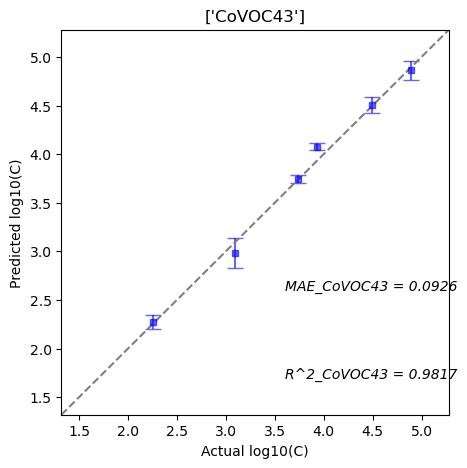

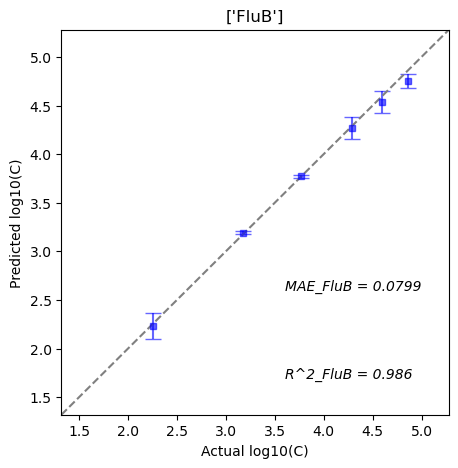

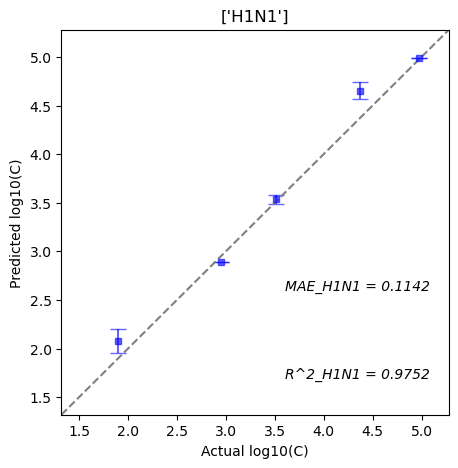

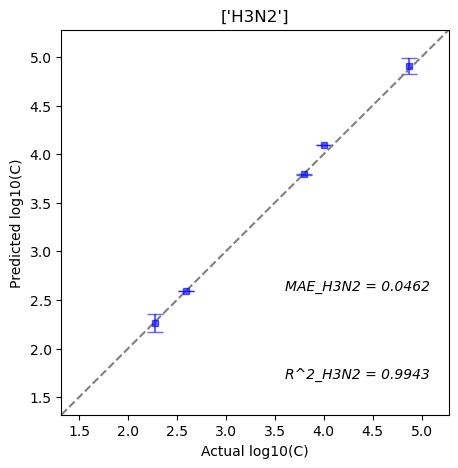

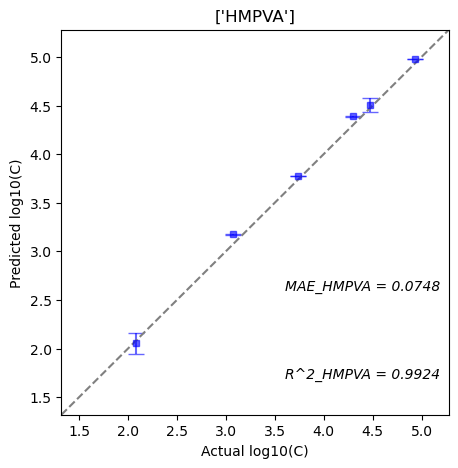

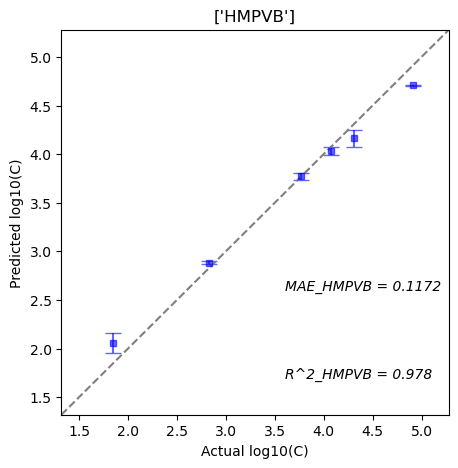

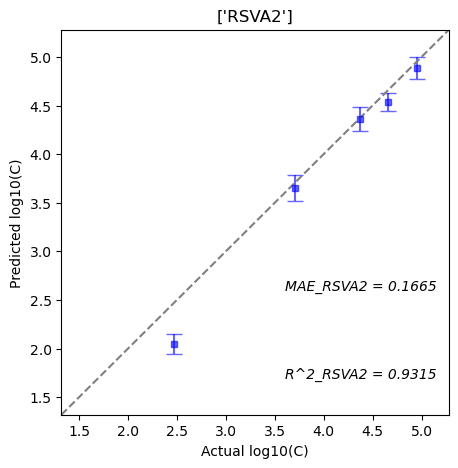

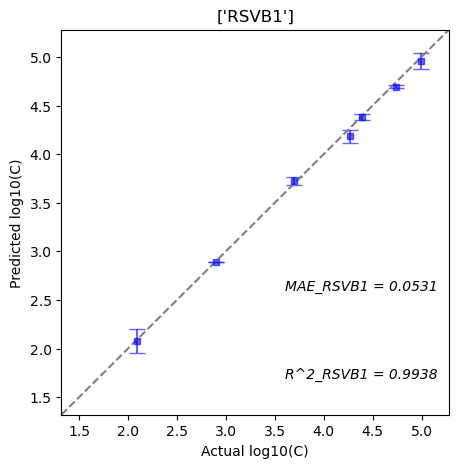

In [74]:
# Draw error bar plots
MAE1_list = []
R1_list = []

for i in range(len(cls)-1):
    plt.figure(figsize=(5, 5))
    single = ast.literal_eval(cls[i])
    ind = np.where(y_true_label==cls[i])
    
    single_y_test_reg = y_test_reg.values[ind,:][0]
    single_y_hat_reg = y_hat_reg[ind,:][0]
    not_outlier = np.where((single_y_hat_reg[:, i] > -25) & (single_y_hat_reg[:, i] < 8))
    real = single_y_test_reg[:,i][not_outlier]
    predicted = single_y_hat_reg[:,i][not_outlier]
    
    c = np.nonzero(np.all(single_y_test_reg != 0, axis=0))[0]
    MAE1, R1 = calculate_MAE_and_R_square(single_y_test_reg[:,c[0]], single_y_hat_reg[:,c[0]])
    MAE1_list.append(MAE1)
    R1_list.append(R1)
    
    for j, (color, marker, label) in enumerate(zip(["blue"], ['s'], single)):
        x_data = real
        y_data = predicted
        
        unique_x = np.unique(x_data)
        mean_y_list = []
        std_y_list = []
        
        for x in unique_x:
            indices = np.where(x_data == x)
            corresponding_y = y_data[indices]
            mean_y = np.mean(corresponding_y)
            std_y = np.std(corresponding_y)
            mean_y_list.append(mean_y)
            std_y_list.append(std_y)
        
        plt.errorbar(unique_x, mean_y_list, yerr=std_y_list, fmt=marker, color=color, alpha=0.6, label=label, capsize=6, markersize=5)

    plt.axline((1.5,1.5),(5.1,5.1),linestyle='--', color="grey")
    plt.text(x=3.6,y=2.6,s="MAE_"+single[0]+" = " +str(round(MAE1,4)),style='oblique')
    plt.text(x=3.6,y=1.7,s="R^2_"+single[0]+" = " +str(round(R1,4)),style='oblique')

    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.title(cls[i])

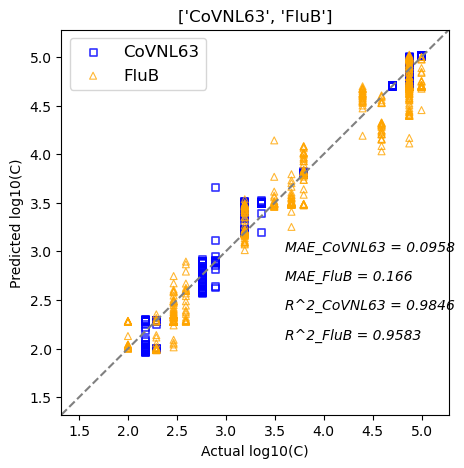

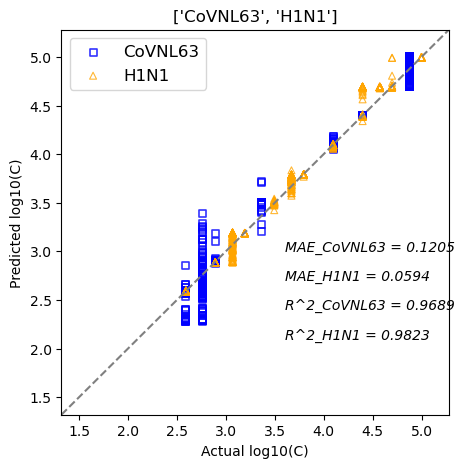

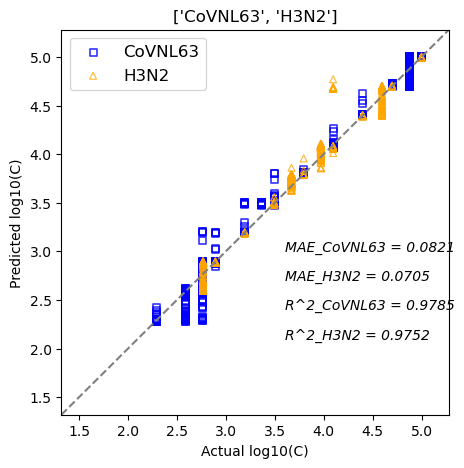

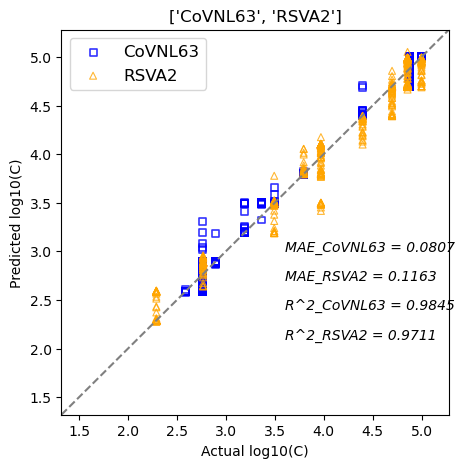

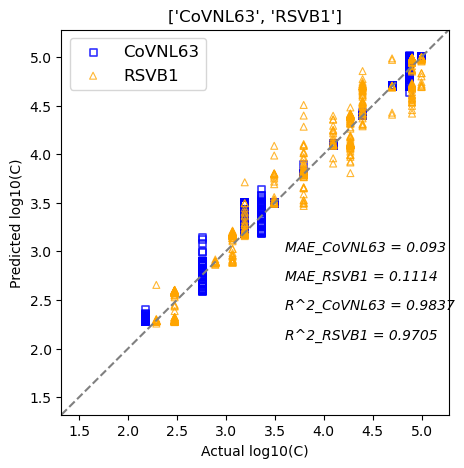

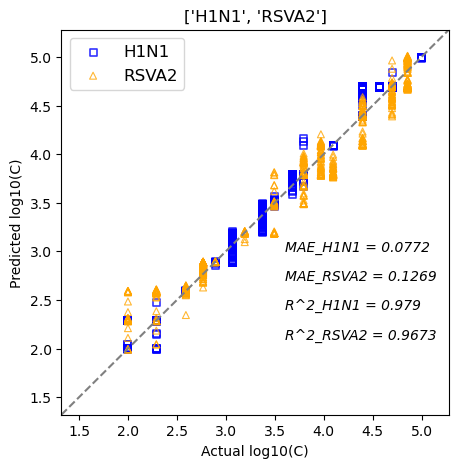

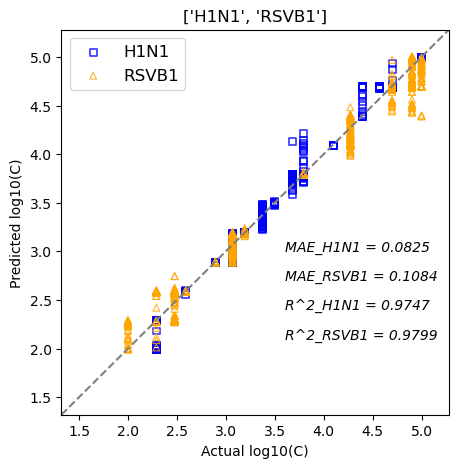

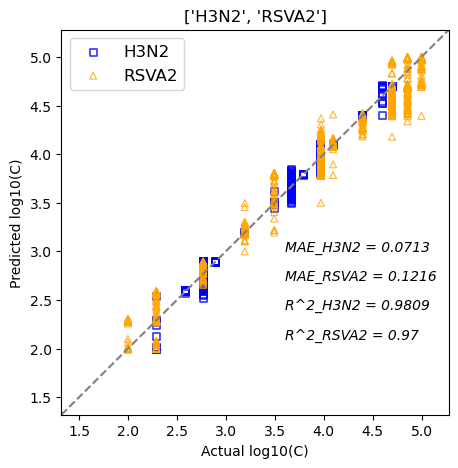

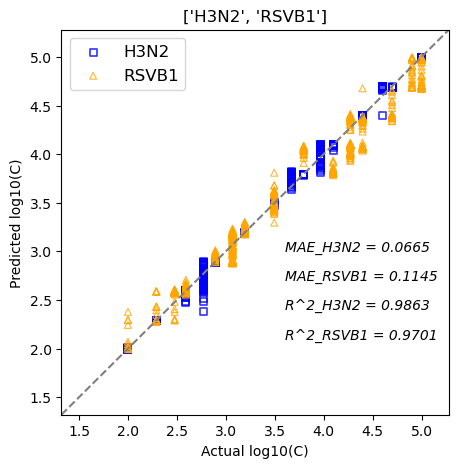

0.0958
0.1205
0.0821
0.0807
0.093
0.0772
0.0825
0.0713
0.0665

0.166
0.0594
0.0705
0.1163
0.1114
0.1269
0.1084
0.1216
0.1145

0.9846
0.9689
0.9785
0.9845
0.9837
0.979
0.9747
0.9809
0.9863

0.9583
0.9823
0.9752
0.9711
0.9705
0.9673
0.9799
0.97
0.9701



In [76]:
## dual mixtures
cls = np.unique(dual_y_true_label)
MAE1_list = []
MAE2_list = []
R1_list = []
R2_list = []

save_folder = r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\Regression\Dual"

for i in range(len(cls)):
    dual = ast.literal_eval(cls[i])
    ind = np.where(y_true_label==cls[i])
    
    dual_y_test_reg = y_test_reg.values[ind,:][0]
    dual_y_hat_reg = y_hat_reg[ind,:][0]
    
    c = np.nonzero(np.all(dual_y_test_reg != 0, axis=0))[0]
    MAE1, R1 = calculate_MAE_and_R_square(dual_y_test_reg[:,c[0]], dual_y_hat_reg[:,c[0]])
    MAE2, R2 = calculate_MAE_and_R_square(dual_y_test_reg[:,c[1]], dual_y_hat_reg[:,c[1]])
    MAE1_list.append(MAE1)
    MAE2_list.append(MAE2)
    R1_list.append(R1)
    R2_list.append(R2)
    
    nn1 = np.where(dual_y_test_reg[:,c[0]]!=0)
    nn2 = np.where(dual_y_test_reg[:,c[1]]!=0)

    # Component 1
    real_conc_1 = dual_y_test_reg[:, c[0]][nn1]
    predicted_conc_1 = dual_y_hat_reg[:, c[0]][nn1]

    # Component 2
    real_conc_2 = dual_y_test_reg[:, c[1]][nn2]
    predicted_conc_2 = dual_y_hat_reg[:, c[1]][nn2]

    # Initialize lists to store the paired concentrations
    real_concentration_pairs = []
    predicted_concentration_pairs = []

    # Combine and append the paired concentrations
    for real_1, pred_1, real_2, pred_2 in zip(real_conc_1, predicted_conc_1, real_conc_2, predicted_conc_2):
        real_concentration_pairs.append([real_1, real_2])
        predicted_concentration_pairs.append([pred_1, pred_2])

    # Create a single summary dict for this Virus_Type
    summary_dict = {
        'Virus_Type': cls[i],
        'Real_Concentration': real_concentration_pairs,
        'Predicted_Concentration': predicted_concentration_pairs
    }
    summary_list.append(summary_dict)
    
    plt.figure(figsize=(5,5))
    plt.scatter(real_conc_1, predicted_conc_1, color="none", marker='s',
            edgecolors="blue", linewidths=1.2, alpha=0.8, s=25, label=dual[0])
    plt.scatter(real_conc_2, predicted_conc_2, color="none", marker='^',
            edgecolors="orange", linewidths=0.8, alpha=0.8, s=25, label=dual[1])

    summary_dual = pd.DataFrame( {
        'Virus_Type': cls[i],
        'Real_Concentration-'+dual[0]: real_conc_1,
        'Predicted_Concentration-'+dual[0]: predicted_conc_1,
        'Real_Concentration-'+dual[1]: real_conc_2,
        'Predicted_Concentration-'+dual[1]: predicted_conc_2,
    })
    
    summary_dual.to_csv(save_folder + r'/' + cls[i] + '.csv',index=True) 
    
    plt.axline((1.5,1.5),(5.1,5.1),linestyle='--', color="grey")
    plt.text(x=3.6,y=3.0,s="MAE_"+dual[0]+" = " +str(round(MAE1,4)),style='oblique')
    plt.text(x=3.6,y=2.7,s="MAE_"+dual[1]+" = " +str(round(MAE2,4)),style='oblique')
    plt.text(x=3.6,y=2.4,s="R^2_"+dual[0]+" = " +str(round(R1,4)),style='oblique')
    plt.text(x=3.6,y=2.1,s="R^2_"+dual[1]+" = " +str(round(R2,4)),style='oblique')

    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.legend(loc='upper left', fontsize='large')
    plt.title(cls[i])
    plt.show()

for item in MAE1_list:
    print(item.round(4))
print()
for item in MAE2_list:
    print(item.round(4))
print()
for item in R1_list:
    print(item.round(4))
print()
for item in R2_list:
    print(item.round(4))
print()

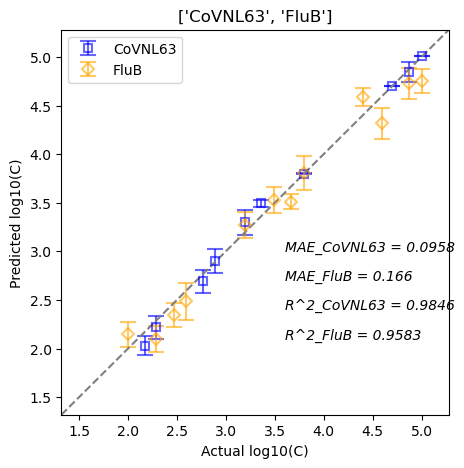

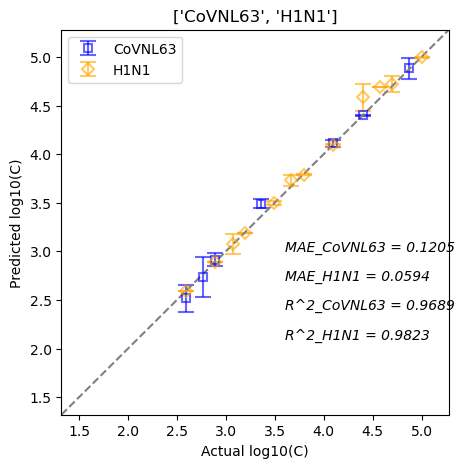

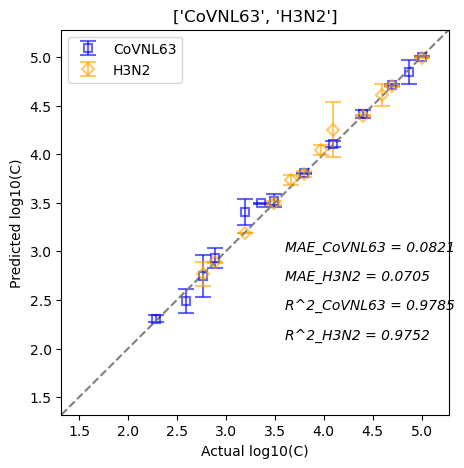

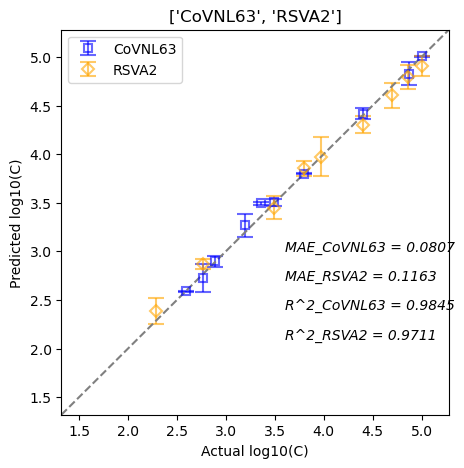

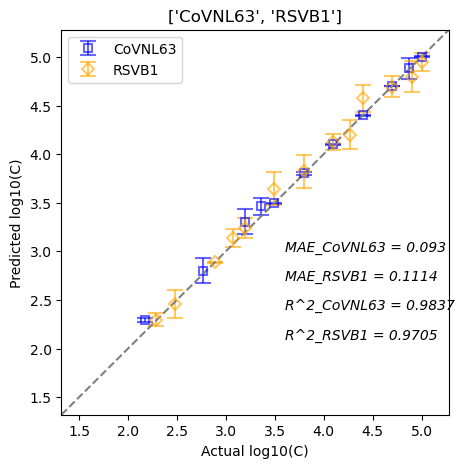

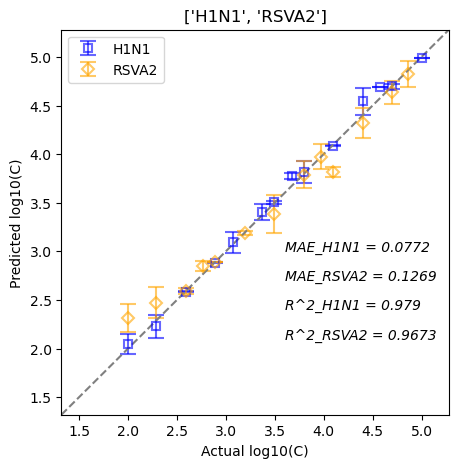

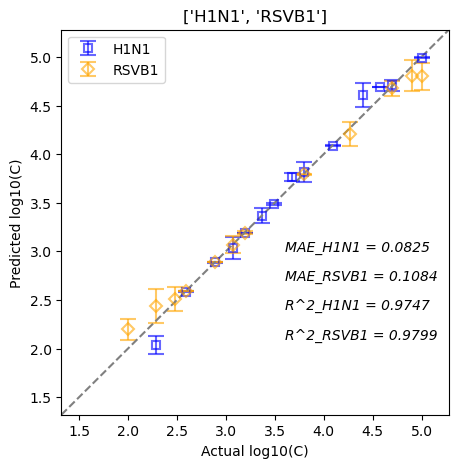

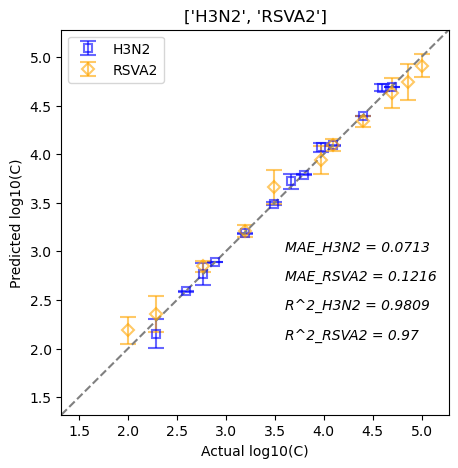

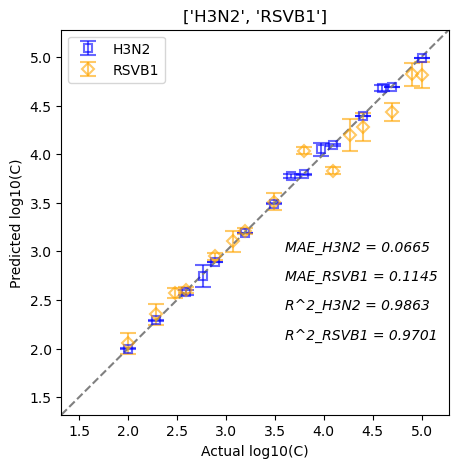

In [78]:
# error bar plots
MAE1_list = []
MAE2_list = []
R1_list = []
R2_list = []

save_folder = r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\Regression\1-Regression - Std\Dual"

for i in range(len(cls)):
    plt.figure(figsize=(5, 5))
    dual = ast.literal_eval(cls[i])
    ind = np.where(y_true_label==cls[i])
    
    dual_y_test_reg = y_test_reg.values[ind,:][0]
    dual_y_hat_reg = y_hat_reg[ind,:][0]
    
    c = np.nonzero(np.all(dual_y_test_reg != 0, axis=0))[0]
    MAE1, R1 = calculate_MAE_and_R_square(dual_y_test_reg[:,c[0]], dual_y_hat_reg[:,c[0]])
    MAE2, R2 = calculate_MAE_and_R_square(dual_y_test_reg[:,c[1]], dual_y_hat_reg[:,c[1]])
    MAE1_list.append(MAE1)
    MAE2_list.append(MAE2)
    R1_list.append(R1)
    R2_list.append(R2)
    
    for j, (color, marker, label) in enumerate(zip(["blue", "orange"], ['s', 'D'], dual)):
        nn = np.where(dual_y_test_reg[:, c[j]] != 0)
        x_data = dual_y_test_reg[:, c[j]][nn]
        y_data = dual_y_hat_reg[:, c[j]][nn]
        
        unique_x = np.unique(x_data)
        mean_y_list = []
        std_y_list = []
        
        for x in unique_x:
            indices = np.where(x_data == x)
            corresponding_y = y_data[indices]
            mean_y = np.mean(corresponding_y)
            std_y = np.std(corresponding_y)
            mean_y_list.append(mean_y)
            std_y_list.append(std_y)
        
        plt.errorbar(unique_x, mean_y_list, yerr=std_y_list, fmt=marker, ecolor=color, alpha=0.6, label=label, capsize=6, markersize=6, markerfacecolor='none', markeredgecolor=color, markeredgewidth=1.5)

        summary_dual_std = pd.DataFrame( {
        'Virus_Type': cls[i],
        'Real_Concentration-'+str(j): unique_x,
        'Predicted_Concentration-'+str(j): mean_y_list,
        'Predicted_Concentration-std-'+str(j): std_y_list,
        #'Real_Concentration-'+dual[1]: real_conc_2,
        #'Predicted_Concentration-'+dual[1]: predicted_conc_2,
        })
        
        summary_dual_std.to_csv(save_folder + r'/' + cls[i] + '-' + str(j) + '.csv',index=True)
    
    plt.axline((1.5,1.5),(5.1,5.1),linestyle='--', color="grey")
    plt.text(x=3.6,y=3.0,s="MAE_"+dual[0]+" = " +str(round(MAE1,4)),style='oblique')
    plt.text(x=3.6,y=2.7,s="MAE_"+dual[1]+" = " +str(round(MAE2,4)),style='oblique')
    plt.text(x=3.6,y=2.4,s="R^2_"+dual[0]+" = " +str(round(R1,4)),style='oblique')
    plt.text(x=3.6,y=2.1,s="R^2_"+dual[1]+" = " +str(round(R2,4)),style='oblique')

    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.legend(loc='upper left')
    plt.title(cls[i])

0.0777
0.0829
0.1092
0.0735

0.0791
0.0767
0.1014
0.1046

0.1117
0.1293
0.1189
0.1427

0.9731
0.9731
0.9557
0.9778

0.9817
0.9819
0.9173
0.9291

0.9207
0.9301
0.92
0.9213



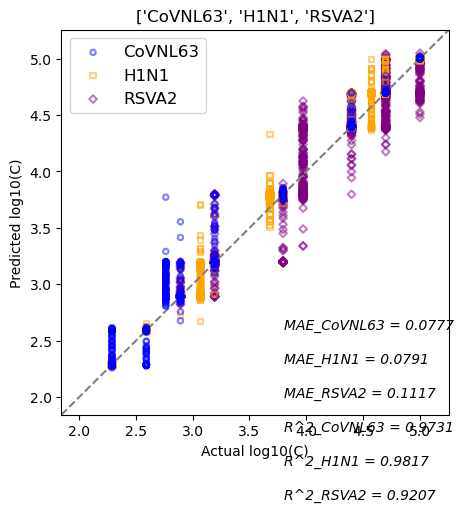

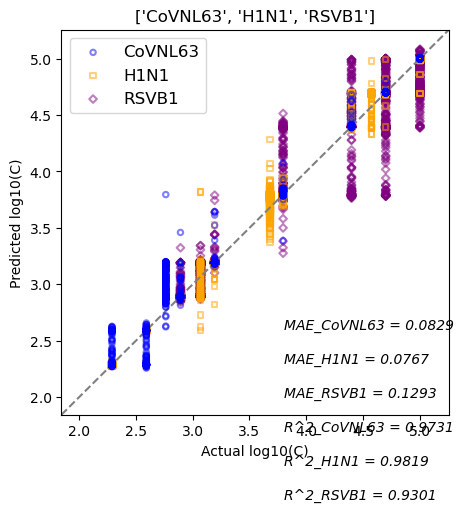

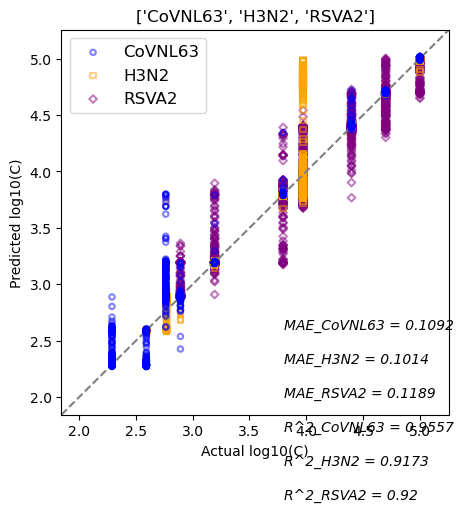

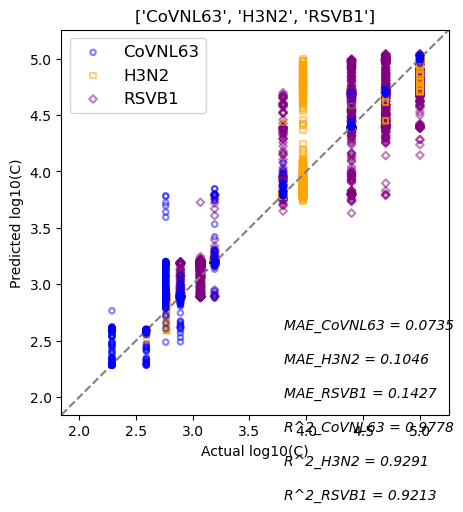

In [80]:
## triple mixtures
cls = np.unique(triple_y_true_label)
MAE1_list = []
MAE2_list = []
MAE3_list = []
R1_list = []
R2_list = []
R3_list = []

save_folder = r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\Regression\Triple"

for i in range(len(cls)):
#     plt.figure(figsize=(11, 11))
    triple = ast.literal_eval(cls[i])
    ind = np.where(y_true_label==cls[i])
    
    triple_y_test_reg = y_test_reg.values[ind,:][0]
    triple_y_hat_reg = y_hat_reg[ind,:][0]
    
    c = np.nonzero(np.all(triple_y_test_reg != 0, axis=0))[0]
    MAE1, R1 = calculate_MAE_and_R_square(triple_y_test_reg[:,c[0]], triple_y_hat_reg[:,c[0]])
    MAE2, R2 = calculate_MAE_and_R_square(triple_y_test_reg[:,c[1]], triple_y_hat_reg[:,c[1]])
    MAE3, R3 = calculate_MAE_and_R_square(triple_y_test_reg[:,c[2]], triple_y_hat_reg[:,c[2]])
    MAE1_list.append(MAE1)
    MAE2_list.append(MAE2)
    MAE3_list.append(MAE3)
    R1_list.append(R1)
    R2_list.append(R2)
    R3_list.append(R3)
    
    nn1 = np.where(triple_y_test_reg[:,c[0]]!=0)
    nn2 = np.where(triple_y_test_reg[:,c[1]]!=0)
    nn3 = np.where(triple_y_test_reg[:,c[2]]!=0)
    
    # Component 1
    real_conc_1 = triple_y_test_reg[:, c[0]][nn1]
    predicted_conc_1 = triple_y_hat_reg[:, c[0]][nn1]

    # Component 2
    real_conc_2 = triple_y_test_reg[:, c[1]][nn2]
    predicted_conc_2 = triple_y_hat_reg[:, c[1]][nn2]
    
    # Component 3
    real_conc_3 = triple_y_test_reg[:, c[2]][nn3]
    predicted_conc_3 = triple_y_hat_reg[:, c[2]][nn3]

    # Initialize lists to store the paired concentrations
    real_concentration_pairs = []
    predicted_concentration_pairs = []

    # Combine and append the paired concentrations
    for real_1, pred_1, real_2, pred_2, real_3, pred_3 in zip(real_conc_1, predicted_conc_1, real_conc_2, predicted_conc_2, real_conc_3, predicted_conc_3):
        real_concentration_pairs.append([real_1, real_2, real_3])
        predicted_concentration_pairs.append([pred_1, pred_2, pred_3])

    # Create a single summary dict for this Virus_Type
    summary_dict = {
        'Virus_Type': cls[i],
        'Real_Concentration': real_concentration_pairs,
        'Predicted_Concentration': predicted_concentration_pairs
    }
    summary_list.append(summary_dict)
    
    plt.figure(figsize=(5,5))
    plt.scatter(real_conc_1, predicted_conc_1, marker='o', 
                color="none", edgecolors="blue", linewidths=1.5, alpha=0.5, s=15, label = triple[0], zorder=3)
    plt.scatter(real_conc_2, predicted_conc_2, marker='s', 
                color="none", edgecolors="orange", linewidths=1.5, alpha=0.5, s=15, label = triple[1], zorder=2)
    plt.scatter(real_conc_3, predicted_conc_3, marker='D', 
                color="none", edgecolors="purple", linewidths=1.5, alpha=0.5, s=15, label = triple[2], zorder=1)

    summary_triple = pd.DataFrame( {
        'Virus_Type': cls[i],
        'Real_Concentration-'+triple[0]: real_conc_1,
        'Predicted_Concentration-'+triple[0]: predicted_conc_1,
        'Real_Concentration-'+triple[1]: real_conc_2,
        'Predicted_Concentration-'+triple[1]: predicted_conc_2,
        'Real_Concentration-'+triple[2]: real_conc_3,
        'Predicted_Concentration-'+triple[2]: predicted_conc_3,
    })
    
    summary_triple.to_csv(save_folder + r'/' + cls[i] + '.csv',index=True)
    
    plt.axline((2,2),(5.1,5.1),linestyle='--', color="grey")
    plt.text(x=3.8,y=2.6,s="MAE_"+triple[0]+" = " +str(round(MAE1,4)),style='oblique')
    plt.text(x=3.8,y=2.3,s="MAE_"+triple[1]+" = " +str(round(MAE2,4)),style='oblique')
    plt.text(x=3.8,y=2,s="MAE_"+triple[2]+" = " +str(round(MAE3,4)),style='oblique')
    plt.text(x=3.8,y=1.7,s="R^2_"+triple[0]+" = " +str(round(R1,4)),style='oblique')
    plt.text(x=3.8,y=1.4,s="R^2_"+triple[1]+" = " +str(round(R2,4)),style='oblique')
    plt.text(x=3.8,y=1.1,s="R^2_"+triple[2]+" = " +str(round(R3,4)),style='oblique')

    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.legend(loc='upper left', fontsize='large')
    plt.title(cls[i])
    
for item in MAE1_list:
    print(item.round(4))
print()
for item in MAE2_list:
    print(item.round(4))
print()
for item in MAE3_list:
    print(item.round(4))
print()
for item in R1_list:
    print(item.round(4))
print()
for item in R2_list:
    print(item.round(4))
print()
for item in R3_list:
    print(item.round(4))
print()
# plt.show()

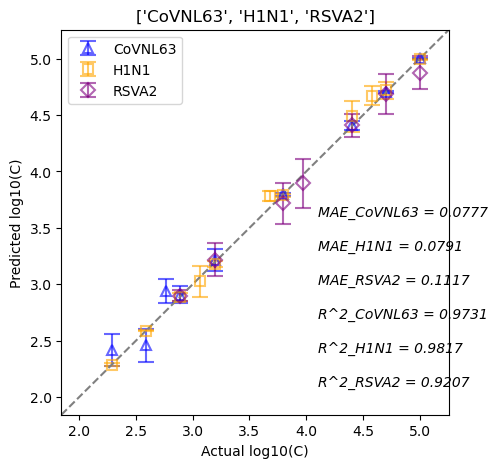

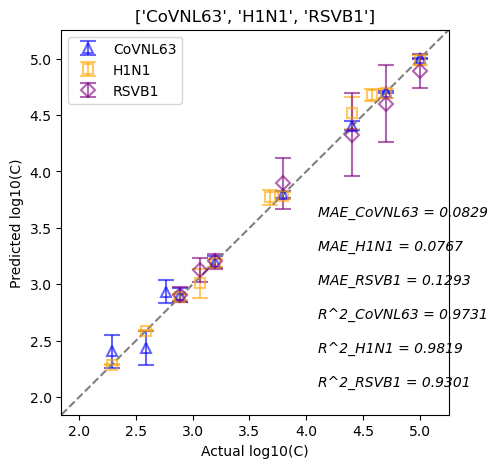

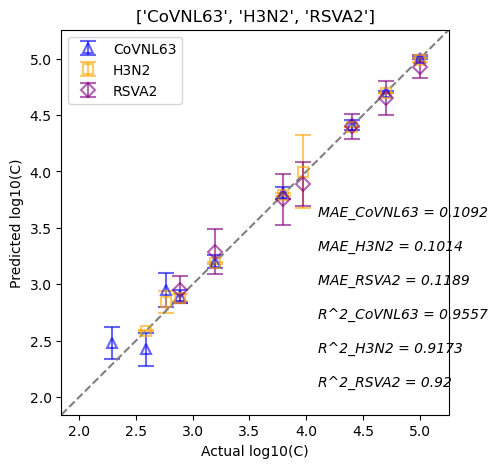

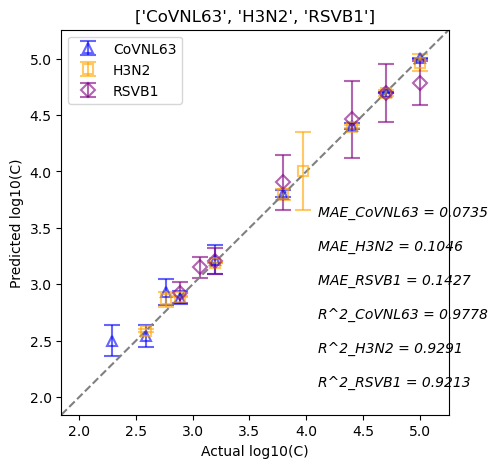

In [82]:
# error bar plots
MAE1_list = []
MAE2_list = []
MAE3_list = []
R1_list = []
R2_list = []
R3_list = []

save_folder = r"C:\My Work and Study\My Study\2-Manuscript\Virus mixture\Results for manuscript\Unknown test\Regression\1-Regression - Std\Triple"

for i in range(len(cls)):
    plt.figure(figsize=(5, 5))
    triple = ast.literal_eval(cls[i])
    ind = np.where(y_true_label==cls[i])
    
    triple_y_test_reg = y_test_reg.values[ind,:][0]
    triple_y_hat_reg = y_hat_reg[ind,:][0]
    
    c = np.nonzero(np.all(triple_y_test_reg != 0, axis=0))[0]
    MAE1, R1 = calculate_MAE_and_R_square(triple_y_test_reg[:,c[0]], triple_y_hat_reg[:,c[0]])
    MAE2, R2 = calculate_MAE_and_R_square(triple_y_test_reg[:,c[1]], triple_y_hat_reg[:,c[1]])
    MAE3, R3 = calculate_MAE_and_R_square(triple_y_test_reg[:,c[2]], triple_y_hat_reg[:,c[2]])
    MAE1_list.append(MAE1)
    MAE2_list.append(MAE2)
    MAE3_list.append(MAE3)
    R1_list.append(R1)
    R2_list.append(R2)
    R3_list.append(R3)
    
    for j, (color, marker, label) in enumerate(zip(["blue", "orange", "purple"], ['^', 's', 'D'], triple)):
        nn = np.where(triple_y_test_reg[:, c[j]] != 0)
        x_data = triple_y_test_reg[:, c[j]][nn]
        y_data = triple_y_hat_reg[:, c[j]][nn]
        
        unique_x = np.unique(x_data)
        mean_y_list = []
        std_y_list = []
        
        for x in unique_x:
            indices = np.where(x_data == x)
            corresponding_y = y_data[indices]
            mean_y = np.mean(corresponding_y)
            std_y = np.std(corresponding_y)
            mean_y_list.append(mean_y)
            std_y_list.append(std_y)
        
        plt.errorbar(unique_x, mean_y_list, yerr=std_y_list, fmt=marker, ecolor=color, alpha=0.6, label=label, capsize=6, markersize=7, markerfacecolor='none', markeredgecolor=color, markeredgewidth=1.5)

        summary_dual_std = pd.DataFrame( {
        'Virus_Type': cls[i],
        'Real_Concentration-'+str(j): unique_x,
        'Predicted_Concentration-'+str(j): mean_y_list,
        'Predicted_Concentration-std-'+str(j): std_y_list,
        #'Real_Concentration-'+dual[1]: real_conc_2,
        #'Predicted_Concentration-'+dual[1]: predicted_conc_2,
        })
        
        summary_dual_std.to_csv(save_folder + r'/' + cls[i] + '-' + str(j) + '.csv',index=True)
    
    plt.axline((2,2),(5.1,5.1),linestyle='--', color="grey")
    plt.text(x=4.1,y=3.6,s="MAE_"+triple[0]+" = " +str(round(MAE1,4)),style='oblique')
    plt.text(x=4.1,y=3.3,s="MAE_"+triple[1]+" = " +str(round(MAE2,4)),style='oblique')
    plt.text(x=4.1,y=3,s="MAE_"+triple[2]+" = " +str(round(MAE3,4)),style='oblique')
    plt.text(x=4.1,y=2.7,s="R^2_"+triple[0]+" = " +str(round(R1,4)),style='oblique')
    plt.text(x=4.1,y=2.4,s="R^2_"+triple[1]+" = " +str(round(R2,4)),style='oblique')
    plt.text(x=4.1,y=2.1,s="R^2_"+triple[2]+" = " +str(round(R3,4)),style='oblique')

    plt.xlabel("Actual log10(C)")
    plt.ylabel("Predicted log10(C)")
    plt.legend(loc='upper left')
    plt.title(cls[i])

In [30]:
## standard deviation of each component in triple mixtures
cls = np.unique(triple_y_true_label)

# Create empty lists to store the data
virus_1_list = []
std_1_list = []
virus_2_list = []
std_2_list = []
virus_3_list = []
std_3_list = []

for i in range(len(cls)):
    triple = ast.literal_eval(cls[i])
    ind = np.where(y_true_label==cls[i])
    
    triple_y_test_reg = y_test_reg.values[ind,:][0]
    triple_y_hat_reg = y_hat_reg[ind,:][0]
    
    c = np.nonzero(np.all(triple_y_test_reg != 0, axis=0))[0]
    nn1 = np.where(triple_y_test_reg[:,c[0]]!=0)
    nn2 = np.where(triple_y_test_reg[:,c[1]]!=0)
    nn3 = np.where(triple_y_test_reg[:,c[2]]!=0)
    
    # Component 1
    real_conc_1 = triple_y_test_reg[:, c[0]][nn1]
    predicted_conc_1 = triple_y_hat_reg[:, c[0]][nn1]

    # Component 2
    real_conc_2 = triple_y_test_reg[:, c[1]][nn2]
    predicted_conc_2 = triple_y_hat_reg[:, c[1]][nn2]
    
    # Component 3
    real_conc_3 = triple_y_test_reg[:, c[2]][nn3]
    predicted_conc_3 = triple_y_hat_reg[:, c[2]][nn3]

    # residual std for Component 1
    residuals_1 = real_conc_1 - predicted_conc_1
    std_1 = np.std(residuals_1)

    # residual std for Component 2
    residuals_2 = real_conc_2 - predicted_conc_2
    std_2 = np.std(residuals_2)
    
    # residual std for Component 3
    residuals_3 = real_conc_3 - predicted_conc_3
    std_3 = np.std(residuals_3)

    print(triple[0] + ": " + str(std_1) + ", " + triple[1] + ": " + str(std_2) + ", " + triple[2] + ": " + str(std_3))

    # Append the data to the respective lists
    virus_1_list.append(triple[0])
    std_1_list.append(std_1)
    virus_2_list.append(triple[1])
    std_2_list.append(std_2)
    virus_3_list.append(triple[2])
    std_3_list.append(std_3)

# Create a dictionary with the data
data = {
    "Virus_1": virus_1_list,
    "Std_1": std_1_list,
    "Virus_2": virus_2_list,
    "Std_2": std_2_list,
    "Virus_3": virus_3_list,
    "Std_3": std_3_list
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

CoVNL63: 0.06769329994842574, H1N1: 0.037558696239131016, RSVA2: 0.08597708657878796
CoVNL63: 0.07144138160996895, H1N1: 0.03229378186243748, RSVB1: 0.10842846375079139
CoVNL63: 0.0717139678492812, H3N2: 0.019625661339753957, RSVA2: 0.08504495097926765
CoVNL63: 0.07447021822352619, H3N2: 0.016737127002700015, RSVB1: 0.11656543119463306


In [ ]:
# Save the DataFrame to a CSV file
df.to_csv("/mnt/data/3_mixture_residual_std.csv", index=False)

In [33]:
summary_list

[{'Virus_Type': 'Ad5',
  'Real_Concentration': array([2.        , 2.        , 2.        , 2.        , 2.        ,
         2.        , 2.        , 2.        , 2.        , 2.        ,
         2.        , 2.        , 2.        , 2.        , 2.        ,
         2.        , 2.        , 2.        , 2.        , 2.        ,
         2.        , 2.        , 2.        , 2.        , 2.        ,
         2.        , 2.        , 2.        , 2.        , 2.        ,
         2.        , 2.        , 2.        , 2.        , 2.        ,
         2.        , 2.        , 2.        , 2.        , 5.        ,
         5.        , 5.        , 5.        , 5.        , 5.        ,
         5.        , 5.        , 5.        , 5.        , 5.        ,
         5.        , 5.        , 5.        , 5.        , 5.        ,
         5.        , 5.        , 5.        , 5.        , 5.        ,
         5.        , 5.        , 5.        , 5.        , 5.        ,
         5.        , 5.        , 5.        , 5.        , 5

In [34]:
# Convert summary_list to DataFrame
summary_df = pd.DataFrame(summary_list)
summary_df

Virus_Type  \
0                            Ad5   
1                        CoV229E   
2                        CoVNL63   
3                        CoVOC43   
4                           FluB   
5                           H1N1   
6                           H3N2   
7                          HMPVA   
8                          HMPVB   
9                          RSVA2   
10                         RSVB1   
11                        saliva   
12           ['CoVNL63', 'FluB']   
13           ['CoVNL63', 'H1N1']   
14           ['CoVNL63', 'H3N2']   
15          ['CoVNL63', 'RSVA2']   
16          ['CoVNL63', 'RSVB1']   
17             ['H1N1', 'RSVA2']   
18             ['H1N1', 'RSVB1']   
19             ['H3N2', 'RSVA2']   
20             ['H3N2', 'RSVB1']   
21  ['CoVNL63', 'H1N1', 'RSVA2']   
22  ['CoVNL63', 'H1N1', 'RSVB1']   
23  ['CoVNL63', 'H3N2', 'RSVA2']   
24  ['CoVNL63', 'H3N2', 'RSVB1']   

                                   Real_Concentration  \
0   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
1   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
2   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
3   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
4   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
5   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
6   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
7   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
8   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
9   [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
10  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
11  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
12  [[5.0, 2.0], [5.0, 2.0], [5.0, 2.0], [5.0, 2.0...   
13  [[5.0, 5.0], [5.0, 5.0], [5.0, 5.0], [5.0, 5.0...   
14  [[5.0, 5.0], [5.0, 5.0], [5.0, 5.0], [5.0, 5.0...   
15  [[5.0, 5.0], [5.0, 5.0], [5.0, 5.0], [5.0, 5.0...   
16  [[5.0, 5.0], [5.0, 5.0], [5.0, 5.0], [5.0, 5.0...   
17  [[5.0, 2.0], [5.0, 2.0], [5.0, 2.0], [5.0, 2.0...   
18  [[5.0, 2.0], [5.0, 2.0], [5.0, 2.0], [5.0, 2.0...   
19  [[5.0, 2.0], [5.0, 2.0], [5.0, 2.0], [5.0, 2.0...   
20  [[5.0, 2.0], [5.0, 2.0], [5.0, 2.0], [5.0, 2.0...   
21  [[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], [5.0, 5.0, ...   
22  [[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], [5.0, 5.0, ...   
23  [[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], [5.0, 5.0, ...   
24  [[5.0, 5.0, 5.0], [5.0, 5.0, 5.0], [5.0, 5.0, ...   

                              Predicted_Concentration  
0   [2.000418, 2.0147598, 2.0614583, 2.2746263, 2....  
1   [2.2673602, 2.25954, 2.0150514, 2.0164547, 2.0...  
2   [2.2699268, 1.9980438, 2.2777789, 2.2811413, 1...  
3   [2.010413, 2.0677998, 2.2965417, 2.2903943, 2....  
4   [2.3100023, 2.0036268, 2.003932, 2.005115, 2.0...  
5   [2.1911023, 2.2673943, 1.9986055, 2.2644312, 2...  
6   [1.9965994, 1.9916065, 2.1734865, 1.9943854, 2...  
7   [2.044706, 1.9938253, 2.0235732, 1.9944432, 1....  
8   [2.284399, 2.000019, 1.9916298, 1.9903479, 2.2...  
9   [2.2730699, 1.9872725, 2.282948, 1.9834929, 1....  
10  [2.281882, 2.2807345, 1.988668, 1.9900355, 2.2...  
11  [1.0028946, 1.0032012, 0.9966275, 1.2147887, 1...  
12  [[5.0091705, 2.594141], [5.0122175, 2.2737694]...  
13  [[5.004042, 4.995509], [5.001684, 4.9939165], ...  
14  [[5.005444, 4.9993176], [5.0092773, 4.9982066]...  
15  [[5.007647, 4.993159], [5.007956, 4.886885], [...  
16  [[5.0038943, 4.9905014], [5.004983, 4.9955044]...  
17  [[4.991423, 2.0390258], [4.991501, 1.991325], ...  
18  [[4.992688, 1.9923847], [4.994476, 1.9921901],...  
19  [[4.9943523, 2.2851272], [4.993128, 2.2870004]...  
20  [[4.995767, 2.2872696], [4.995398, 2.2856662],...  
21  [[5.0041094, 4.9944673, 4.9955983], [5.0010643...  
22  [[5.0037313, 4.992822, 4.9867315], [4.999083, ...  
23  [[5.0038934, 4.995469, 4.9944744], [5.004282, ...  
24  [[5.001635, 4.9959483, 4.989663], [5.0025377, ...